In [1]:
# Import libraries
import os
import sys
import requests
import sqlalchemy
from sqlalchemy.sql import text

from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())

from utils.database import get_db
import utils.models as models

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# from config import ACCOUNT_NUMBER, ACCOUNT_PASSWORD, CONSUMER_ID, REDIRECT_URI

# Create connection to Database and extraction of required data

In [2]:
# create connection to the database
db = get_db()

In [3]:
# Define requested ticker ID:
ticker_id = 41

In [4]:
# set the presentation format of float numbers within the dataframe

pd.set_option('display.float_format', lambda x: '%.3f' % x)

### Fetch "daily multipliers" table from database

In [5]:
query = db.query(models.FullDailyMultipliers)
df_daily_multipliers = pd.read_sql(query.statement, query.session.bind)
df_daily_multipliers.head()
# len(df_daily_multipliers.index)
df_daily_multipliers[df_daily_multipliers.isna().any(axis=1)]

,id,date,stock_id,market_cap,enterprise_val,pe_ratio,pb_ratio,trailing_peg_1_y
73,74,2013-03-31,1,NaN,NaN,NaN,NaN,13.372
138,139,2013-06-30,1,NaN,NaN,NaN,NaN,4.769
1023,1024,2016-12-31,1,NaN,NaN,NaN,NaN,1.616
1212,1213,2017-09-30,1,NaN,NaN,NaN,NaN,2.706
1276,1277,2017-12-31,1,NaN,NaN,NaN,NaN,-0.474
...,...,...,...,...,...,...,...,...
1214116,1214117,2018-03-31,503,NaN,NaN,NaN,NaN,0.954
1214181,1214182,2018-06-30,503,NaN,NaN,NaN,NaN,0.738
1214245,1214246,2018-09-30,503,NaN,NaN,NaN,NaN,2.227
1214370,1214371,2019-03-31,503,NaN,NaN,NaN,NaN,-3.510


In [6]:
# Choose the stock_id we want to check (ticker_id)
daily_multipliers = df_daily_multipliers.loc[df_daily_multipliers['stock_id'] == ticker_id]

# Delete all dates > 2.1.13
daily_multipliers = daily_multipliers.query('"2013-01-01" < date').copy().reset_index(drop=True)


daily_multipliers.head()
# df_daily_multipliers[df_daily_multipliers.isna().any(axis=1)]

,id,date,stock_id,market_cap,enterprise_val,pe_ratio,pb_ratio,trailing_peg_1_y
0,96463,2013-01-02,41,10916100000.000,11680100000.000,19.791,4.470,0.770
1,96464,2013-01-03,41,10776600000.000,11540600000.000,19.538,4.413,0.760
2,96465,2013-01-04,41,10733300000.000,11497300000.000,19.459,4.395,0.757
3,96466,2013-01-07,41,10747700000.000,11511700000.000,19.485,4.401,0.758
4,96467,2013-01-08,41,10693200000.000,11457200000.000,19.387,4.379,0.754


### Fetch "end of day prices" table from database

In [7]:

query = db.query(models.EndOfDayPrices)
df_end_of_day_prices = pd.read_sql(query.statement, query.session.bind)
df_end_of_day_prices.head()

# len(df_end_of_day_prices.head().index)


,id,stock_id,date,close_price
0,1,1,2012-01-03,83.490
1,2,1,2012-01-04,84.180
2,3,1,2012-01-05,83.800
3,4,1,2012-01-06,83.370
4,5,1,2012-01-09,83.870


### Select specific stock from end of day prices table (Apple Stock)

In [8]:
# Choose the stock_id we want to check (ticker_id)
end_of_day_prices = df_end_of_day_prices.loc[df_end_of_day_prices['stock_id'] == ticker_id]

# Delete all dates > 2.1.13
end_of_day_prices = end_of_day_prices.query('"2013-01-01" < date').copy().reset_index(drop=True)


end_of_day_prices.head()
end_of_day_prices[end_of_day_prices.isna().any(axis=1)]

,id,stock_id,date,close_price


### Fetch "pfree cash flow multiplier" table from database

In [9]:
# fetch the end of day prices table from database

query = db.query(models.PFreeCashFlowMultiplier)
df_pfree_cash_flow = pd.read_sql(query.statement, query.session.bind)
# df_pfree_cash_flow.head()

# Choose the stock_id we want to check (ticker_id)
pfree_cash_flow = df_pfree_cash_flow.loc[df_pfree_cash_flow['stock_id'] == ticker_id]

# Delete all dates > 2.1.13
pfree_cash_flow = pfree_cash_flow.query('"2013-01-01" < date').copy().reset_index(drop=True)


pfree_cash_flow.shape
pfree_cash_flow[pfree_cash_flow.isna().any(axis=1)]


,id,stock_id,date,year,quarter,pfree_cash_flow_ratio
2267,112318,41,2022-01-03,2022,1,NaN
2268,112319,41,2022-01-04,2022,1,NaN
2269,112320,41,2022-01-05,2022,1,NaN
2270,112321,41,2022-01-06,2022,1,NaN
2271,112322,41,2022-01-07,2022,1,NaN
...,...,...,...,...,...,...
2490,112541,41,2022-11-21,2022,4,NaN
2491,112542,41,2022-11-22,2022,4,NaN
2492,112543,41,2022-11-23,2022,4,NaN
2493,112544,41,2022-11-25,2022,4,NaN


### Fetch "graham number" table from database

In [10]:
# fetch the end of day prices table from database

query = db.query(models.GrahamNumber)
df_graham_number = pd.read_sql(query.statement, query.session.bind)
# df_pfree_cash_flow.head()

# Choose the stock_id we want to check (ticker_id)
graham_number = df_graham_number.loc[df_graham_number['stock_id'] == ticker_id]

# filter year =< 2012
graham_number = graham_number.query('2012 < year').copy().reset_index(drop=True)

# df_graham_number.dtypes
graham_number.shape

graham_number[graham_number.isna().any(axis=1)]


,id,stock_id,year,quarter,graham_value
0,1648,41,2022,1,NaN
1,1649,41,2022,2,NaN
2,1650,41,2022,3,NaN


### Fetch "overview data" table from database

In [11]:
# fetch the overview data table from database

overview = models.QuarterlyOverview
query = db.query(overview.stock_id, overview.year, overview.quarter, overview.currentRatio )
df_overview_data = pd.read_sql(query.statement, query.session.bind)
# df_pfree_cash_flow.head()

# Choose the stock_id we want to check (ticker_id)
overview_data = df_overview_data.loc[df_overview_data['stock_id'] == ticker_id]

# filter year =< 2012
overview_data = overview_data.query('2012 < year').copy().reset_index(drop=True)

# df_graham_number.dtypes
# overview_data.shape

overview_data

overview_data[overview_data.isna().any(axis=1)]

,stock_id,year,quarter,currentRatio
4,41,2021,0,NaN
9,41,2020,0,NaN
14,41,2019,0,NaN
19,41,2018,0,NaN
24,41,2017,0,NaN
29,41,2016,0,NaN
34,41,2015,0,NaN
39,41,2014,0,NaN
44,41,2013,0,NaN


# Preprocessing of the data

# Join all five dataframes

In [12]:
# First, combine the two dataframes: "end of day prices" and "daily multipliers" into one joined dataframe (using outer join to maintain all rows)
joined_dataframe = pd.merge(end_of_day_prices, daily_multipliers, on='date', how='inner')

# Create 2 new columns for "date_plus_3m" & "market_cap_plus_3m"
day_gap = 60
date_plus_3m = joined_dataframe.loc[day_gap:,'date'].values
market_cap_plus_3m = joined_dataframe.loc[day_gap:,'market_cap'].values


joined_dataframe.drop(joined_dataframe.tail(day_gap).index, inplace = True)
joined_dataframe['date_plus_3m'] = date_plus_3m
joined_dataframe['market_cap_plus_3m'] = market_cap_plus_3m

# Rename columns
joined_dataframe.rename(columns = {'id_x': 'id', 'stock_id_x':'stock_id'}, inplace=True)

# Setting the index column to column 'id'
joined_dataframe['id'] = joined_dataframe.index

# Dropping redundant columns
joined_dataframe = joined_dataframe.drop(['stock_id_y', 'id_y'], axis=1)

# Rename dataframe for clarity purposes
multiplier_with_closing_prices = joined_dataframe

multiplier_with_closing_prices

# Check for Nan values in joined dataframe
multiplier_with_closing_prices[multiplier_with_closing_prices.isna().any(axis=1)]

,id,stock_id,date,close_price,market_cap,enterprise_val,pe_ratio,pb_ratio,trailing_peg_1_y,date_plus_3m,market_cap_plus_3m


In [13]:
# Second, join the two dataframes: "multiplier_with_closing_prices" and "pfree_cash_flow" into one joined dataframe (using outer join to maintain all rows)

joined_dataframe = pd.merge(multiplier_with_closing_prices, pfree_cash_flow, on='date', how='left')

# Rename columns
joined_dataframe.rename(columns = {'id_x': 'id', 'stock_id_x':'stock_id'}, inplace=True)

# Convert "date" column's type from object to datetime and "stock id" to int
joined_dataframe['date'] = pd.to_datetime(joined_dataframe['date'])
joined_dataframe['stock_id'] = joined_dataframe['stock_id'].astype('int')

# Handle Nan values that were formed due to the left join of the two dataframes
joined_dataframe["pfree_cash_flow_ratio"] = joined_dataframe["pfree_cash_flow_ratio"].interpolate(axis=0, limit_area='inside', limit=5)

joined_dataframe["year"] = joined_dataframe["date"].dt.year
joined_dataframe['quarter'] = joined_dataframe['date'].dt.quarter

# Setting the index column to column 'id'
joined_dataframe['id'] = joined_dataframe.index

# Dropping redundant columns
joined_dataframe = joined_dataframe.drop(['stock_id_y', 'id_y'], axis=1)

# Rename dataframe for clarity purposes
multiplier_with_closing_prices_and_cash_flow = joined_dataframe

# multiplier_with_closing_prices_and_cash_flow

# multiplier_with_closing_prices_and_cash_flow.head()
multiplier_with_closing_prices_and_cash_flow[multiplier_with_closing_prices_and_cash_flow.isna().any(axis=1)]



,id,stock_id,date,close_price,market_cap,enterprise_val,pe_ratio,pb_ratio,trailing_peg_1_y,date_plus_3m,market_cap_plus_3m,year,quarter,pfree_cash_flow_ratio
2267,2267,41,2022-01-03,86.500,51729400000.000,55287900000.000,32.519,8.109,1.084,2022-03-30,45944700000.000,2022,1,NaN
2268,2268,41,2022-01-04,86.770,51890900000.000,55449400000.000,32.620,8.135,1.087,2022-03-31,45130100000.000,2022,1,NaN
2269,2269,41,2022-01-05,85.120,50904100000.000,54462600000.000,32.000,7.980,1.067,2022-04-01,45261900000.000,2022,1,NaN
2270,2270,41,2022-01-06,85.190,50946000000.000,54504500000.000,32.026,7.986,1.068,2022-04-04,45513400000.000,2022,1,NaN
2271,2271,41,2022-01-07,82.120,49110000000.000,52668500000.000,30.872,7.699,1.029,2022-04-05,44555100000.000,2022,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2430,2430,41,2022-08-26,75.470,44891700000.000,48419600000.000,25.241,6.889,0.921,2022-11-21,47351700000.000,2022,3,NaN
2431,2431,41,2022-08-29,74.760,44469400000.000,47997300000.000,25.003,6.824,0.912,2022-11-22,47655200000.000,2022,3,NaN
2432,2432,41,2022-08-30,74.170,44118400000.000,47646300000.000,24.806,6.770,0.905,2022-11-23,47649200000.000,2022,3,NaN
2433,2433,41,2022-08-31,73.530,43737700000.000,47265600000.000,24.592,6.712,0.897,2022-11-25,47809900000.000,2022,3,NaN


In [14]:
# Next, merge the dataframe - "graham number", which has quarterly data with the previously joined dataframe,

joined_dataframe = pd.merge(multiplier_with_closing_prices_and_cash_flow, graham_number, on=['year', 'quarter'], how='left')

# Rename columns
joined_dataframe.rename(columns = {'id_x': 'id', 'stock_id_x':'stock_id'}, inplace=True)

# Dropping redundant columns
joined_dataframe = joined_dataframe.drop(['stock_id_y', 'id_y'], axis=1)

# Rename dataframe for clarity purposes
four_joined_dataframes = joined_dataframe

# four_joined_dataframes.head()

four_joined_dataframes[four_joined_dataframes.isna().any(axis=1)]

,id,stock_id,date,close_price,market_cap,enterprise_val,pe_ratio,pb_ratio,trailing_peg_1_y,date_plus_3m,market_cap_plus_3m,year,quarter,pfree_cash_flow_ratio,graham_value
2267,2267,41,2022-01-03,86.500,51729400000.000,55287900000.000,32.519,8.109,1.084,2022-03-30,45944700000.000,2022,1,NaN,NaN
2268,2268,41,2022-01-04,86.770,51890900000.000,55449400000.000,32.620,8.135,1.087,2022-03-31,45130100000.000,2022,1,NaN,NaN
2269,2269,41,2022-01-05,85.120,50904100000.000,54462600000.000,32.000,7.980,1.067,2022-04-01,45261900000.000,2022,1,NaN,NaN
2270,2270,41,2022-01-06,85.190,50946000000.000,54504500000.000,32.026,7.986,1.068,2022-04-04,45513400000.000,2022,1,NaN,NaN
2271,2271,41,2022-01-07,82.120,49110000000.000,52668500000.000,30.872,7.699,1.029,2022-04-05,44555100000.000,2022,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2430,2430,41,2022-08-26,75.470,44891700000.000,48419600000.000,25.241,6.889,0.921,2022-11-21,47351700000.000,2022,3,NaN,NaN
2431,2431,41,2022-08-29,74.760,44469400000.000,47997300000.000,25.003,6.824,0.912,2022-11-22,47655200000.000,2022,3,NaN,NaN
2432,2432,41,2022-08-30,74.170,44118400000.000,47646300000.000,24.806,6.770,0.905,2022-11-23,47649200000.000,2022,3,NaN,NaN
2433,2433,41,2022-08-31,73.530,43737700000.000,47265600000.000,24.592,6.712,0.897,2022-11-25,47809900000.000,2022,3,NaN,NaN


In [15]:
# Finally, merge the remaining dataframe - "overview", which has quarterly data with the previously joined dataframe,


joined_dataframe = pd.merge(four_joined_dataframes, overview_data, on=['stock_id', 'year', 'quarter'], how='left')

# Rename dataframe for clarity purposes
final_joined_dataframe = joined_dataframe

# final_joined_dataframe.head()
final_joined_dataframe[final_joined_dataframe.isna().any(axis=1)]

# final_joined_dataframe

,id,stock_id,date,close_price,market_cap,enterprise_val,pe_ratio,pb_ratio,trailing_peg_1_y,date_plus_3m,market_cap_plus_3m,year,quarter,pfree_cash_flow_ratio,graham_value,currentRatio
2267,2267,41,2022-01-03,86.500,51729400000.000,55287900000.000,32.519,8.109,1.084,2022-03-30,45944700000.000,2022,1,NaN,NaN,2.548
2268,2268,41,2022-01-04,86.770,51890900000.000,55449400000.000,32.620,8.135,1.087,2022-03-31,45130100000.000,2022,1,NaN,NaN,2.548
2269,2269,41,2022-01-05,85.120,50904100000.000,54462600000.000,32.000,7.980,1.067,2022-04-01,45261900000.000,2022,1,NaN,NaN,2.548
2270,2270,41,2022-01-06,85.190,50946000000.000,54504500000.000,32.026,7.986,1.068,2022-04-04,45513400000.000,2022,1,NaN,NaN,2.548
2271,2271,41,2022-01-07,82.120,49110000000.000,52668500000.000,30.872,7.699,1.029,2022-04-05,44555100000.000,2022,1,NaN,NaN,2.548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2430,2430,41,2022-08-26,75.470,44891700000.000,48419600000.000,25.241,6.889,0.921,2022-11-21,47351700000.000,2022,3,NaN,NaN,2.383
2431,2431,41,2022-08-29,74.760,44469400000.000,47997300000.000,25.003,6.824,0.912,2022-11-22,47655200000.000,2022,3,NaN,NaN,2.383
2432,2432,41,2022-08-30,74.170,44118400000.000,47646300000.000,24.806,6.770,0.905,2022-11-23,47649200000.000,2022,3,NaN,NaN,2.383
2433,2433,41,2022-08-31,73.530,43737700000.000,47265600000.000,24.592,6.712,0.897,2022-11-25,47809900000.000,2022,3,NaN,NaN,2.383


In [16]:
# create a new column - "diff_in_market_cap_perc" where:
# 1. calculates the change in market cap value 3 months apart and presents the difference in percentage

col1 = final_joined_dataframe['market_cap']
col2 = final_joined_dataframe['market_cap_plus_3m']

final_joined_dataframe['diff_in_mc'] = col2.sub(col1, axis=0)
final_joined_dataframe['diff_in_mc_perc'] = ((col2.sub(col1, axis=0)).div(col1)).mul(100)

# final_joined_dataframe.shape
final_joined_dataframe.head(200)

# final_joined_dataframe[final_joined_dataframe.isna().any(axis=1)]

,id,stock_id,date,close_price,market_cap,enterprise_val,pe_ratio,pb_ratio,trailing_peg_1_y,date_plus_3m,market_cap_plus_3m,year,quarter,pfree_cash_flow_ratio,graham_value,currentRatio,diff_in_mc,diff_in_mc_perc
0,0,41,2013-01-02,68.080,10916100000.000,11680100000.000,19.791,4.470,0.770,2013-04-01,11741000000.000,2013,1,70.783,9.321,3.344,824900000.000,7.557
1,1,41,2013-01-03,67.210,10776600000.000,11540600000.000,19.538,4.413,0.760,2013-04-02,11771300000.000,2013,1,69.878,9.321,3.344,994700000.000,9.230
2,2,41,2013-01-04,66.940,10733300000.000,11497300000.000,19.459,4.395,0.757,2013-04-03,11709100000.000,2013,1,69.597,9.321,3.344,975800000.000,9.091
3,3,41,2013-01-07,67.030,10747700000.000,11511700000.000,19.485,4.401,0.758,2013-04-04,11694700000.000,2013,1,69.691,9.321,3.344,947000000.000,8.811
4,4,41,2013-01-08,66.690,10693200000.000,11457200000.000,19.387,4.379,0.754,2013-04-05,11506200000.000,2013,1,69.338,9.321,3.344,813000000.000,7.603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,195,41,2013-10-10,76.180,12124700000.000,12710600000.000,19.942,4.547,1.684,2014-01-07,13903400000.000,2013,4,78.502,10.015,1.961,1778700000.000,14.670
196,196,41,2013-10-11,77.050,12263200000.000,12849100000.000,20.170,4.599,1.703,2014-01-08,13981000000.000,2013,4,79.398,10.015,1.961,1717800000.000,14.008
197,197,41,2013-10-14,77.100,12271100000.000,12857100000.000,20.183,4.602,1.704,2014-01-09,14153500000.000,2013,4,79.450,10.015,1.961,1882400000.000,15.340
198,198,41,2013-10-15,77.450,12326800000.000,12912800000.000,20.275,4.623,1.712,2014-01-10,14140800000.000,2013,4,79.810,10.015,1.961,1814000000.000,14.716


# 1. Optimizing the random forest model

In [17]:
# Define requested model and label thresholds:

label_threshold_lst = [1, 5, 10, 15, 20]

model_threshold_lst = [0.7, 0.75, 0.8, 0.85, 0.9, 0.95]


In [18]:
# First, convert "date_plus_3m" columns type from 'string' to 'datetime'
final_joined_dataframe['date_plus_3m'] = pd.to_datetime(final_joined_dataframe['date_plus_3m'])

# Split the data to 60% train, 20% validation, 20% test
train = final_joined_dataframe.query('"2013-01-01" < date <= "2017-03-30"').copy()
validation = final_joined_dataframe.query('"2017-03-30" < date <= "2018-08-29"').copy()
test = final_joined_dataframe.query('"2018-08-29" < date <= "2020-02-01"').copy()


# Set the x (=features)
X_Cols = ['enterprise_val','pe_ratio','pb_ratio','trailing_peg_1_y', 'pfree_cash_flow_ratio', 'graham_value', 'currentRatio']

# Split X to train and test
X_train, X_validation = train[X_Cols], validation[X_Cols]


In [19]:
train.shape

(1069, 18)

In [20]:
validation.shape

(357, 18)

In [21]:
test.shape

(357, 18)

In [22]:
# Model optimization using ParameterGrid() - ~percentage~ of profit

profit_with_params_dict = {}
# y_pred_dict_per_model = {} # Saving the prediction of each model so we could show all ROC curves

rf_clf_full_params = {
                'n_estimators':[51,101,151], # The number of trees in the forest
                'criterion':["gini", "entropy"], # The function to measure the quality of a split.
                'max_depth':[5, 7, 9, 11],    # The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples
                'max_features':[3, 5, 7, 8], # The number of features to consider when looking for the best split results
                'random_state':[711]
                 }


# classifier = RandomForestClassifier
params = rf_clf_full_params
all_rf_params_permutations = list(ParameterGrid(params))
# print(len(list(ParameterGrid(params))))
# print(list(ParameterGrid(params)))

# Loop through different model parameters in order to find the optimized set of parameters for the requested stock, testing on a validation set:
for label_thresh in tqdm(label_threshold_lst, desc="label threshold"):
    # final_joined_dataframe['label'] = (final_joined_dataframe["diff_in_mc_perc"] > label_thresh).astype(int)    # create the label column  according to the first two parameters - label and model threshold
    train['label'] = (train["diff_in_mc_perc"] > label_thresh).astype(int)
    validation['label'] = (validation["diff_in_mc_perc"] > label_thresh).astype(int)
    Y_Cols = ['label']
    y_train, y_validation = train[Y_Cols].values.ravel(), validation[Y_Cols].values.ravel()  # this changes according to the tested label threshold, therefor inserted into the for loop
    for model_thresh in tqdm(model_threshold_lst, desc="model threshold"):
        for params in tqdm(all_rf_params_permutations, desc="model params"):
            rand_frst_clf = RandomForestClassifier(**params)  # run through the different classifier's parameters options
            rand_frst_clf.fit(X_train, y_train)   # fit (train) the data to the model
            y_pred_proba = rand_frst_clf.predict_proba(X_validation)[:,1] # Make predictions (validation)
            y_pred = y_pred_proba > model_thresh
            validation['prediction'] = y_pred.astype(int)
            validation['profit_percentage'] = validation['diff_in_mc_perc'] * validation['prediction']
            profit_perc_sum = round(validation['profit_percentage'].sum(), 3)
            profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)
            print('profit_perc_sum', profit_perc_sum, 'profit_perc_mean', profit_perc_mean, 'denominator', validation[validation['prediction']==1].shape[0])
            profit_with_params_dict[profit_perc_mean] = [label_thresh, model_thresh, params]

profit_keys_lst = list(profit_with_params_dict.keys())
profit_keys_lst_not_null = [i for i in profit_keys_lst if not pd.isna(i)]
profit_keys_lst_not_null.sort(reverse=True)
max_profit_perc_in_sorted_dict = {i: profit_with_params_dict[i] for i in profit_keys_lst_not_null[:5]}

print(max_profit_perc_in_sorted_dict)

model threshold:   0%|          | 0/6 [00:00<?, ?it/s]

model params:   0%|          | 0/96 [00:00<?, ?it/s]

model params:   2%|▏         | 2/96 [00:00<00:12,  7.72it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357
profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:   3%|▎         | 3/96 [00:00<00:16,  5.51it/s]

model params:   4%|▍         | 4/96 [00:00<00:14,  6.32it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357
profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:   5%|▌         | 5/96 [00:00<00:16,  5.52it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:   6%|▋         | 6/96 [00:01<00:21,  4.28it/s]

model params:   7%|▋         | 7/96 [00:01<00:18,  4.89it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357
profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:   8%|▊         | 8/96 [00:01<00:20,  4.38it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:   9%|▉         | 9/96 [00:02<00:24,  3.51it/s]

model params:  10%|█         | 10/96 [00:02<00:20,  4.12it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357
profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  11%|█▏        | 11/96 [00:02<00:21,  3.94it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  12%|█▎        | 12/96 [00:02<00:25,  3.31it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357
profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  15%|█▍        | 14/96 [00:03<00:18,  4.35it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  16%|█▌        | 15/96 [00:03<00:19,  4.12it/s]

model params:  17%|█▋        | 16/96 [00:03<00:17,  4.68it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357
profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  18%|█▊        | 17/96 [00:03<00:17,  4.42it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  19%|█▉        | 18/96 [00:04<00:20,  3.72it/s]

model params:  20%|█▉        | 19/96 [00:04<00:18,  4.19it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357
profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  21%|██        | 20/96 [00:04<00:19,  3.82it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  22%|██▏       | 21/96 [00:05<00:24,  3.07it/s]

model params:  23%|██▎       | 22/96 [00:05<00:20,  3.59it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357
profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  24%|██▍       | 23/96 [00:05<00:21,  3.42it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  25%|██▌       | 24/96 [00:06<00:24,  2.88it/s]

model params:  26%|██▌       | 25/96 [00:06<00:19,  3.56it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357
profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  27%|██▋       | 26/96 [00:06<00:18,  3.89it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  28%|██▊       | 27/96 [00:06<00:18,  3.72it/s]

model params:  29%|██▉       | 28/96 [00:06<00:15,  4.34it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357
profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  30%|███       | 29/96 [00:07<00:16,  4.10it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  31%|███▏      | 30/96 [00:07<00:19,  3.41it/s]

model params:  32%|███▏      | 31/96 [00:07<00:16,  3.89it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357
profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  33%|███▎      | 32/96 [00:08<00:17,  3.58it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  34%|███▍      | 33/96 [00:08<00:21,  2.88it/s]



profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357
profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357


model params:  35%|███▌      | 34/96 [00:08<00:18,  3.35it/s]

model params:  36%|███▋      | 35/96 [00:09<00:19,  3.15it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  38%|███▊      | 36/96 [00:09<00:22,  2.68it/s]

model params:  39%|███▊      | 37/96 [00:09<00:17,  3.40it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357
profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  40%|███▉      | 38/96 [00:09<00:15,  3.69it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  41%|████      | 39/96 [00:10<00:15,  3.58it/s]

model params:  42%|████▏     | 40/96 [00:10<00:13,  4.19it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357
profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  43%|████▎     | 41/96 [00:10<00:13,  3.96it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  44%|████▍     | 42/96 [00:11<00:16,  3.35it/s]



profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357
profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357


model params:  45%|████▍     | 43/96 [00:11<00:14,  3.78it/s]

model params:  46%|████▌     | 44/96 [00:11<00:15,  3.36it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  47%|████▋     | 45/96 [00:12<00:18,  2.74it/s]

model params:  48%|████▊     | 46/96 [00:12<00:15,  3.24it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357
profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  49%|████▉     | 47/96 [00:12<00:16,  3.01it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  50%|█████     | 48/96 [00:13<00:18,  2.54it/s]

model params:  51%|█████     | 49/96 [00:13<00:14,  3.23it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357
profit_perc_sum 1048.498 profit_perc_mean 4.28 denominator 245




model params:  52%|█████▏    | 50/96 [00:13<00:12,  3.63it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  53%|█████▎    | 51/96 [00:13<00:12,  3.56it/s]

model params:  54%|█████▍    | 52/96 [00:14<00:10,  4.19it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357
profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  55%|█████▌    | 53/96 [00:14<00:10,  4.02it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  56%|█████▋    | 54/96 [00:14<00:12,  3.41it/s]

model params:  57%|█████▋    | 55/96 [00:14<00:10,  3.90it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357
profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  58%|█████▊    | 56/96 [00:15<00:11,  3.54it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  59%|█████▉    | 57/96 [00:15<00:13,  2.88it/s]

model params:  60%|██████    | 58/96 [00:15<00:11,  3.39it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357
profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  61%|██████▏   | 59/96 [00:16<00:11,  3.23it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  62%|██████▎   | 60/96 [00:16<00:14,  2.49it/s]

model params:  64%|██████▎   | 61/96 [00:17<00:11,  3.05it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357
profit_perc_sum 555.474 profit_perc_mean 3.679 denominator 151




model params:  65%|██████▍   | 62/96 [00:17<00:10,  3.28it/s]

profit_perc_sum 690.385 profit_perc_mean 4.315 denominator 160




model params:  66%|██████▌   | 63/96 [00:17<00:10,  3.06it/s]



profit_perc_sum 690.385 profit_perc_mean 4.315 denominator 160
profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357


model params:  67%|██████▋   | 64/96 [00:17<00:09,  3.55it/s]

model params:  68%|██████▊   | 65/96 [00:18<00:08,  3.47it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  69%|██████▉   | 66/96 [00:18<00:10,  2.99it/s]



profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357
profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357


model params:  70%|██████▉   | 67/96 [00:18<00:08,  3.42it/s]

model params:  71%|███████   | 68/96 [00:19<00:09,  2.88it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  72%|███████▏  | 69/96 [00:19<00:11,  2.35it/s]



profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357
profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357


model params:  73%|███████▎  | 70/96 [00:20<00:09,  2.81it/s]

model params:  74%|███████▍  | 71/96 [00:20<00:09,  2.70it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  75%|███████▌  | 72/96 [00:21<00:10,  2.29it/s]

model params:  76%|███████▌  | 73/96 [00:21<00:07,  2.91it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357
profit_perc_sum 690.385 profit_perc_mean 4.315 denominator 160




model params:  77%|███████▋  | 74/96 [00:21<00:06,  3.21it/s]

profit_perc_sum 938.861 profit_perc_mean 4.012 denominator 234




model params:  78%|███████▊  | 75/96 [00:21<00:06,  3.11it/s]

model params:  79%|███████▉  | 76/96 [00:21<00:05,  3.66it/s]

profit_perc_sum 1038.613 profit_perc_mean 3.157 denominator 329
profit_perc_sum 1127.527 profit_perc_mean 3.637 denominator 310




model params:  80%|████████  | 77/96 [00:22<00:05,  3.50it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  81%|████████▏ | 78/96 [00:22<00:06,  2.94it/s]



profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357
profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357


model params:  82%|████████▏ | 79/96 [00:22<00:05,  3.35it/s]

model params:  83%|████████▎ | 80/96 [00:23<00:05,  2.98it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  84%|████████▍ | 81/96 [00:23<00:06,  2.43it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  85%|████████▌ | 82/96 [00:24<00:04,  2.86it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  86%|████████▋ | 83/96 [00:24<00:04,  2.75it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  88%|████████▊ | 84/96 [00:25<00:05,  2.31it/s]

model params:  89%|████████▊ | 85/96 [00:25<00:03,  2.95it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357
profit_perc_sum 690.385 profit_perc_mean 4.315 denominator 160




model params:  90%|████████▉ | 86/96 [00:25<00:03,  3.25it/s]

profit_perc_sum 1016.646 profit_perc_mean 4.184 denominator 243




model params:  91%|█████████ | 87/96 [00:25<00:02,  3.13it/s]

model params:  92%|█████████▏| 88/96 [00:25<00:02,  3.65it/s]

profit_perc_sum 1190.676 profit_perc_mean 3.402 denominator 350
profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  93%|█████████▎| 89/96 [00:26<00:02,  3.48it/s]

profit_perc_sum 1256.867 profit_perc_mean 3.531 denominator 356




model params:  94%|█████████▍| 90/96 [00:26<00:02,  2.92it/s]

profit_perc_sum 1256.867 profit_perc_mean 3.531 denominator 356
profit_perc_sum 1257.272 profit_perc_mean 3.532 denominator 356




model params:  95%|█████████▍| 91/96 [00:26<00:01,  3.30it/s]

model params:  96%|█████████▌| 92/96 [00:27<00:01,  2.99it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  97%|█████████▋| 93/96 [00:27<00:01,  2.41it/s]



profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357
profit_perc_sum 1257.272 profit_perc_mean 3.532 denominator 356


model params:  98%|█████████▊| 94/96 [00:28<00:00,  2.82it/s]

model params:  99%|█████████▉| 95/96 [00:28<00:00,  2.48it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params: 100%|██████████| 96/96 [00:30<00:00,  3.18it/s]

model threshold:  17%|█▋        | 1/6 [00:30<02:31, 30.24s/it]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:   0%|          | 0/96 [00:00<?, ?it/s]

profit_perc_sum



model params:   1%|          | 1/96 [00:00<00:17,  5.46it/s]

 1262.881 profit_perc_mean 3.537 denominator 357




model params:   2%|▏         | 2/96 [00:00<00:25,  3.63it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:   3%|▎         | 3/96 [00:00<00:33,  2.78it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:   4%|▍         | 4/96 [00:01<00:28,  3.27it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:   5%|▌         | 5/96 [00:01<00:31,  2.92it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:   6%|▋         | 6/96 [00:02<00:44,  2.04it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:   7%|▋         | 7/96 [00:02<00:36,  2.44it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:   8%|▊         | 8/96 [00:03<00:37,  2.35it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:   9%|▉         | 9/96 [00:03<00:43,  2.01it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  10%|█         | 10/96 [00:03<00:35,  2.41it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  11%|█▏        | 11/96 [00:04<00:35,  2.42it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  12%|█▎        | 12/96 [00:04<00:39,  2.15it/s]

model params:  14%|█▎        | 13/96 [00:05<00:30,  2.69it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357
profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  15%|█▍        | 14/96 [00:05<00:28,  2.85it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  16%|█▌        | 15/96 [00:05<00:30,  2.70it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  17%|█▋        | 16/96 [00:06<00:25,  3.09it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  18%|█▊        | 17/96 [00:06<00:27,  2.91it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  19%|█▉        | 18/96 [00:06<00:30,  2.56it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  20%|█▉        | 19/96 [00:07<00:26,  2.95it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  21%|██        | 20/96 [00:07<00:27,  2.75it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  22%|██▏       | 21/96 [00:08<00:33,  2.27it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  23%|██▎       | 22/96 [00:08<00:27,  2.68it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  24%|██▍       | 23/96 [00:08<00:28,  2.53it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  25%|██▌       | 24/96 [00:09<00:33,  2.13it/s]

model params:  26%|██▌       | 25/96 [00:09<00:26,  2.65it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357
profit_perc_sum 834.161 profit_perc_mean 2.648 denominator 315




model params:  27%|██▋       | 26/96 [00:09<00:24,  2.81it/s]

profit_perc_sum 1080.943 profit_perc_mean 4.256 denominator 254




model params:  28%|██▊       | 27/96 [00:10<00:26,  2.65it/s]

profit_perc_sum 1309.763 profit_perc_mean 4.694 denominator 279
profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  29%|██▉       | 28/96 [00:10<00:22,  3.09it/s]

model params:  30%|███       | 29/96 [00:10<00:22,  2.98it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  31%|███▏      | 30/96 [00:11<00:26,  2.51it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  32%|███▏      | 31/96 [00:11<00:23,  2.81it/s]

profit_perc_sum 1223.566 profit_perc_mean 3.466 denominator 353




model params:  33%|███▎      | 32/96 [00:12<00:25,  2.53it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  34%|███▍      | 33/96 [00:12<00:31,  2.02it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  35%|███▌      | 34/96 [00:13<00:26,  2.36it/s]

profit_perc_sum 1223.566 profit_perc_mean 3.466 denominator 353




model params:  36%|███▋      | 35/96 [00:13<00:26,  2.27it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  38%|███▊      | 36/96 [00:14<00:30,  1.96it/s]

model params:  39%|███▊      | 37/96 [00:14<00:23,  2.48it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357
profit_perc_sum 874.15 profit_perc_mean 2.698 denominator 324




model params:  40%|███▉      | 38/96 [00:14<00:21,  2.71it/s]

profit_perc_sum 906.149 profit_perc_mean 2.771 denominator 327




model params:  41%|████      | 39/96 [00:15<00:24,  2.37it/s]

profit_perc_sum 1068.264 profit_perc_mean 4.222 denominator 253




model params:  42%|████▏     | 40/96 [00:15<00:20,  2.72it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  43%|████▎     | 41/96 [00:16<00:21,  2.61it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  44%|████▍     | 42/96 [00:16<00:23,  2.26it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  45%|████▍     | 43/96 [00:16<00:20,  2.59it/s]

profit_perc_sum 1206.854 profit_perc_mean 3.429 denominator 352




model params:  46%|████▌     | 44/96 [00:17<00:21,  2.43it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  47%|████▋     | 45/96 [00:18<00:25,  2.04it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  48%|████▊     | 46/96 [00:18<00:21,  2.36it/s]

profit_perc_sum 1206.854 profit_perc_mean 3.429 denominator 352




model params:  49%|████▉     | 47/96 [00:18<00:21,  2.31it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  50%|█████     | 48/96 [00:19<00:24,  2.00it/s]

model params:  51%|█████     | 49/96 [00:19<00:18,  2.52it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357
profit_perc_sum 690.385 profit_perc_mean 4.315 denominator 160




model params:  52%|█████▏    | 50/96 [00:19<00:16,  2.71it/s]

profit_perc_sum 918.38 profit_perc_mean 3.959 denominator 232




model params:  53%|█████▎    | 51/96 [00:20<00:18,  2.49it/s]

profit_perc_sum 918.38 profit_perc_mean 3.959 denominator 232
profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  54%|█████▍    | 52/96 [00:20<00:15,  2.92it/s]

model params:  55%|█████▌    | 53/96 [00:20<00:14,  2.87it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  56%|█████▋    | 54/96 [00:21<00:17,  2.45it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  57%|█████▋    | 55/96 [00:21<00:14,  2.76it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  58%|█████▊    | 56/96 [00:22<00:15,  2.51it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  59%|█████▉    | 57/96 [00:22<00:18,  2.10it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  60%|██████    | 58/96 [00:23<00:15,  2.46it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  61%|██████▏   | 59/96 [00:23<00:15,  2.32it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  62%|██████▎   | 60/96 [00:24<00:18,  2.00it/s]

model params:  64%|██████▎   | 61/96 [00:24<00:13,  2.51it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357
profit_perc_sum 263.043 profit_perc_mean 2.229 denominator 118




model params:  65%|██████▍   | 62/96 [00:24<00:12,  2.68it/s]

profit_perc_sum 660.312 profit_perc_mean 4.179 denominator 158




model params:  66%|██████▌   | 63/96 [00:25<00:13,  2.52it/s]

profit_perc_sum 690.385 profit_perc_mean 4.315 denominator 160




model params:  67%|██████▋   | 64/96 [00:25<00:11,  2.89it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  68%|██████▊   | 65/96 [00:25<00:11,  2.68it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  69%|██████▉   | 66/96 [00:26<00:13,  2.22it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  70%|██████▉   | 67/96 [00:26<00:11,  2.51it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  71%|███████   | 68/96 [00:27<00:12,  2.32it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  72%|███████▏  | 69/96 [00:27<00:14,  1.91it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  73%|███████▎  | 70/96 [00:28<00:11,  2.22it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  74%|███████▍  | 71/96 [00:28<00:11,  2.13it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  75%|███████▌  | 72/96 [00:29<00:13,  1.81it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357
profit_perc_sum 568.767 profit_perc_mean 3.817 denominator 149




model params:  76%|███████▌  | 73/96 [00:29<00:10,  2.27it/s]

model params:  77%|███████▋  | 74/96 [00:30<00:09,  2.34it/s]

profit_perc_sum 690.385 profit_perc_mean 4.315 denominator 160




model params:  78%|███████▊  | 75/96 [00:30<00:10,  2.06it/s]

profit_perc_sum 690.385 profit_perc_mean 4.315 denominator 160




model params:  79%|███████▉  | 76/96 [00:31<00:08,  2.35it/s]

profit_perc_sum 752.37 profit_perc_mean 4.505 denominator 167




model params:  80%|████████  | 77/96 [00:31<00:08,  2.18it/s]

profit_perc_sum 1148.045 profit_perc_mean 5.39 denominator 213




model params:  81%|████████▏ | 78/96 [00:32<00:09,  1.84it/s]

profit_perc_sum 1318.697 profit_perc_mean 4.866 denominator 271




model params:  82%|████████▏ | 79/96 [00:32<00:08,  2.06it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  83%|████████▎ | 80/96 [00:33<00:08,  1.95it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  84%|████████▍ | 81/96 [00:34<00:09,  1.51it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  85%|████████▌ | 82/96 [00:34<00:07,  1.77it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  86%|████████▋ | 83/96 [00:35<00:07,  1.74it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  88%|████████▊ | 84/96 [00:35<00:07,  1.58it/s]

model params:  89%|████████▊ | 85/96 [00:36<00:05,  2.01it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357
profit_perc_sum 683.937 profit_perc_mean 4.301 denominator 159




model params:  90%|████████▉ | 86/96 [00:36<00:04,  2.22it/s]

profit_perc_sum 690.385 profit_perc_mean 4.315 denominator 160




model params:  91%|█████████ | 87/96 [00:36<00:04,  2.18it/s]

profit_perc_sum 690.385 profit_perc_mean 4.315 denominator 160




model params:  92%|█████████▏| 88/96 [00:37<00:03,  2.57it/s]

profit_perc_sum 1182.908 profit_perc_mean 5.281 denominator 224




model params:  93%|█████████▎| 89/96 [00:37<00:02,  2.48it/s]

profit_perc_sum 703.065 profit_perc_mean 4.367 denominator 161




model params:  94%|█████████▍| 90/96 [00:38<00:02,  2.09it/s]

profit_perc_sum 1042.603 profit_perc_mean 5.111 denominator 204




model params:  95%|█████████▍| 91/96 [00:38<00:02,  2.34it/s]

profit_perc_sum 1119.462 profit_perc_mean 3.382 denominator 331




model params:  96%|█████████▌| 92/96 [00:39<00:01,  2.17it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  97%|█████████▋| 93/96 [00:39<00:01,  1.80it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  98%|█████████▊| 94/96 [00:40<00:00,  2.10it/s]

profit_perc_sum 1119.462 profit_perc_mean 3.382 denominator 331




model params:  99%|█████████▉| 95/96 [00:40<00:00,  2.02it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params: 100%|██████████| 96/96 [00:41<00:00,  2.31it/s]

model threshold:  33%|███▎      | 2/6 [01:11<02:27, 36.86s/it]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:   0%|          | 0/96 [00:00<?, ?it/s]

model params:   1%|          | 1/96 [00:00<00:12,  7.52it/s]

profit_perc_sum 1056.83 profit_perc_mean 3.127 denominator 338




model params:   2%|▏         | 2/96 [00:00<00:20,  4.67it/s]

profit_perc_sum 895.82 profit_perc_mean 3.406 denominator 263




model params:   3%|▎         | 3/96 [00:00<00:26,  3.45it/s]

profit_perc_sum 1080.943 profit_perc_mean 4.256 denominator 254
profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:   4%|▍         | 4/96 [00:00<00:22,  4.07it/s]

model params:   5%|▌         | 5/96 [00:01<00:25,  3.60it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:   6%|▋         | 6/96 [00:01<00:31,  2.86it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357
profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:   7%|▋         | 7/96 [00:01<00:26,  3.33it/s]

model params:   8%|▊         | 8/96 [00:02<00:28,  3.11it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:   9%|▉         | 9/96 [00:02<00:34,  2.54it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357
profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  10%|█         | 10/96 [00:03<00:28,  3.00it/s]

model params:  11%|█▏        | 11/96 [00:03<00:29,  2.91it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  12%|█▎        | 12/96 [00:04<00:34,  2.41it/s]

model params:  14%|█▎        | 13/96 [00:04<00:27,  2.98it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357
profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  15%|█▍        | 14/96 [00:04<00:27,  2.94it/s]

profit_perc_sum 1027.003 profit_perc_mean 4.092 denominator 251




model params:  16%|█▌        | 15/96 [00:05<00:34,  2.34it/s]

profit_perc_sum 1260.156 profit_perc_mean 4.582 denominator 275




model params:  17%|█▋        | 16/96 [00:05<00:30,  2.60it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  18%|█▊        | 17/96 [00:06<00:35,  2.21it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  19%|█▉        | 18/96 [00:07<00:51,  1.51it/s]

profit_perc_sum 1237.718 profit_perc_mean 3.487 denominator 355




model params:  20%|█▉        | 19/96 [00:07<00:45,  1.69it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  21%|██        | 20/96 [00:08<00:50,  1.52it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  22%|██▏       | 21/96 [00:09<00:59,  1.27it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  23%|██▎       | 22/96 [00:09<00:49,  1.50it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  24%|██▍       | 23/96 [00:10<00:47,  1.55it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  25%|██▌       | 24/96 [00:11<00:47,  1.52it/s]

model params:  26%|██▌       | 25/96 [00:11<00:36,  1.96it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357
profit_perc_sum 1054.509 profit_perc_mean 4.545 denominator 232




model params:  27%|██▋       | 26/96 [00:11<00:32,  2.17it/s]

profit_perc_sum 662.341 profit_perc_mean 4.273 denominator 155




model params:  28%|██▊       | 27/96 [00:12<00:31,  2.17it/s]

profit_perc_sum 742.812 profit_perc_mean 4.557 denominator 163




model params:  29%|██▉       | 28/96 [00:12<00:26,  2.53it/s]

profit_perc_sum 1223.566 profit_perc_mean 3.466 denominator 353




model params:  30%|███       | 29/96 [00:12<00:26,  2.48it/s]

profit_perc_sum 911.431 profit_perc_mean 2.893 denominator 315




model params:  31%|███▏      | 30/96 [00:13<00:29,  2.23it/s]

profit_perc_sum 1229.58 profit_perc_mean 3.473 denominator 354




model params:  32%|███▏      | 31/96 [00:13<00:25,  2.58it/s]

profit_perc_sum 1223.566 profit_perc_mean 3.466 denominator 353




model params:  33%|███▎      | 32/96 [00:14<00:26,  2.44it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  34%|███▍      | 33/96 [00:14<00:30,  2.04it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  35%|███▌      | 34/96 [00:15<00:26,  2.37it/s]

profit_perc_sum 1223.566 profit_perc_mean 3.466 denominator 353




model params:  36%|███▋      | 35/96 [00:15<00:26,  2.30it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  38%|███▊      | 36/96 [00:16<00:30,  1.99it/s]

model params:  39%|███▊      | 37/96 [00:16<00:23,  2.50it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357
profit_perc_sum 858.509 profit_perc_mean 3.85 denominator 223




model params:  40%|███▉      | 38/96 [00:16<00:21,  2.70it/s]

profit_perc_sum 817.949 profit_perc_mean 4.131 denominator 198




model params:  41%|████      | 39/96 [00:17<00:22,  2.49it/s]

profit_perc_sum 647.04 profit_perc_mean 4.174 denominator 155
profit_perc_sum 1223.566 profit_perc_mean 3.466 denominator 353




model params:  42%|████▏     | 40/96 [00:17<00:19,  2.92it/s]

model params:  43%|████▎     | 41/96 [00:17<00:19,  2.87it/s]

profit_perc_sum 1227.467 profit_perc_mean 3.467 denominator 354




model params:  44%|████▍     | 42/96 [00:18<00:22,  2.40it/s]

profit_perc_sum 1227.467 profit_perc_mean 3.467 denominator 354




model params:  45%|████▍     | 43/96 [00:18<00:19,  2.70it/s]

profit_perc_sum 735.658 profit_perc_mean 4.432 denominator 166




model params:  46%|████▌     | 44/96 [00:19<00:20,  2.48it/s]

profit_perc_sum 1146.163 profit_perc_mean 3.322 denominator 345




model params:  47%|████▋     | 45/96 [00:19<00:24,  2.07it/s]

profit_perc_sum 1105.344 profit_perc_mean 3.241 denominator 341




model params:  48%|████▊     | 46/96 [00:19<00:20,  2.41it/s]

profit_perc_sum 735.658 profit_perc_mean 4.432 denominator 166




model params:  49%|████▉     | 47/96 [00:20<00:21,  2.33it/s]

profit_perc_sum 1146.163 profit_perc_mean 3.322 denominator 345




model params:  50%|█████     | 48/96 [00:21<00:24,  1.98it/s]

model params:  51%|█████     | 49/96 [00:21<00:18,  2.51it/s]

profit_perc_sum 1105.344 profit_perc_mean 3.241 denominator 341
profit_perc_sum 495.278 profit_perc_mean 9.172 denominator 54




model params:  52%|█████▏    | 50/96 [00:21<00:16,  2.72it/s]

profit_perc_sum 677.024 profit_perc_mean 4.258 denominator 159




model params:  53%|█████▎    | 51/96 [00:21<00:17,  2.52it/s]

profit_perc_sum 690.385 profit_perc_mean 4.315 denominator 160
profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  54%|█████▍    | 52/96 [00:22<00:14,  2.95it/s]

model params:  55%|█████▌    | 53/96 [00:22<00:14,  2.89it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  56%|█████▋    | 54/96 [00:23<00:16,  2.47it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  57%|█████▋    | 55/96 [00:23<00:14,  2.78it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  58%|█████▊    | 56/96 [00:23<00:15,  2.54it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  59%|█████▉    | 57/96 [00:24<00:18,  2.10it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  60%|██████    | 58/96 [00:24<00:15,  2.45it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  61%|██████▏   | 59/96 [00:25<00:17,  2.17it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  62%|██████▎   | 60/96 [00:26<00:21,  1.71it/s]



profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357
profit_perc_sum 201.69 profit_perc_mean 1.885 denominator 107


model params:  64%|██████▎   | 61/96 [00:26<00:16,  2.16it/s]

model params:  65%|██████▍   | 62/96 [00:26<00:15,  2.25it/s]

profit_perc_sum 216.061 profit_perc_mean 1.964 denominator 110




model params:  66%|██████▌   | 63/96 [00:27<00:15,  2.17it/s]

profit_perc_sum 369.723 profit_perc_mean 3.056 denominator 121




model params:  67%|██████▋   | 64/96 [00:27<00:12,  2.54it/s]

profit_perc_sum 1343.347 profit_perc_mean 3.905 denominator 344




model params:  68%|██████▊   | 65/96 [00:27<00:12,  2.48it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  69%|██████▉   | 66/96 [00:28<00:14,  2.13it/s]

profit_perc_sum 1318.697 profit_perc_mean 4.866 denominator 271




model params:  70%|██████▉   | 67/96 [00:28<00:12,  2.41it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  71%|███████   | 68/96 [00:29<00:12,  2.22it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  72%|███████▏  | 69/96 [00:30<00:14,  1.86it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  73%|███████▎  | 70/96 [00:30<00:12,  2.11it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  74%|███████▍  | 71/96 [00:30<00:12,  2.02it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  75%|███████▌  | 72/96 [00:31<00:13,  1.75it/s]



profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357
profit_perc_sum 233.67 profit_perc_mean 2.164 denominator 108


model params:  76%|███████▌  | 73/96 [00:31<00:10,  2.19it/s]

model params:  77%|███████▋  | 74/96 [00:32<00:09,  2.43it/s]

profit_perc_sum 585.258 profit_perc_mean 4.21 denominator 139




model params:  78%|███████▊  | 75/96 [00:32<00:09,  2.25it/s]

profit_perc_sum 554.051 profit_perc_mean 3.821 denominator 145




model params:  79%|███████▉  | 76/96 [00:33<00:07,  2.54it/s]

profit_perc_sum 454.439 profit_perc_mean 3.884 denominator 117




model params:  80%|████████  | 77/96 [00:33<00:08,  2.34it/s]

profit_perc_sum 616.621 profit_perc_mean 4.195 denominator 147




model params:  81%|████████▏ | 78/96 [00:34<00:09,  1.98it/s]

profit_perc_sum 668.422 profit_perc_mean 4.369 denominator 153




model params:  82%|████████▏ | 79/96 [00:34<00:07,  2.22it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  83%|████████▎ | 80/96 [00:35<00:08,  1.99it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  84%|████████▍ | 81/96 [00:36<00:09,  1.67it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  85%|████████▌ | 82/96 [00:36<00:07,  1.95it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  86%|████████▋ | 83/96 [00:36<00:07,  1.86it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  88%|████████▊ | 84/96 [00:37<00:07,  1.61it/s]

model params:  89%|████████▊ | 85/96 [00:37<00:05,  2.05it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357
profit_perc_sum 230.53 profit_perc_mean 5.489 denominator 42




model params:  90%|████████▉ | 86/96 [00:38<00:04,  2.29it/s]

profit_perc_sum 622.152 profit_perc_mean 4.176 denominator 149




model params:  91%|█████████ | 87/96 [00:38<00:04,  2.20it/s]

profit_perc_sum 536.681 profit_perc_mean 3.753 denominator 143




model params:  92%|█████████▏| 88/96 [00:38<00:03,  2.56it/s]

profit_perc_sum 685.538 profit_perc_mean 4.423 denominator 155




model params:  93%|█████████▎| 89/96 [00:39<00:02,  2.43it/s]

profit_perc_sum 506.686 profit_perc_mean 3.898 denominator 130




model params:  94%|█████████▍| 90/96 [00:40<00:02,  2.10it/s]

profit_perc_sum 585.258 profit_perc_mean 4.21 denominator 139




model params:  95%|█████████▍| 91/96 [00:40<00:02,  2.34it/s]

profit_perc_sum 205.612 profit_perc_mean 1.922 denominator 107




model params:  96%|█████████▌| 92/96 [00:40<00:01,  2.17it/s]

profit_perc_sum 1225.301 profit_perc_mean 4.749 denominator 258




model params:  97%|█████████▋| 93/96 [00:41<00:01,  1.82it/s]

profit_perc_sum 1226.276 profit_perc_mean 3.494 denominator 351




model params:  98%|█████████▊| 94/96 [00:41<00:00,  2.11it/s]

profit_perc_sum 205.612 profit_perc_mean 1.922 denominator 107




model params:  99%|█████████▉| 95/96 [00:42<00:00,  2.03it/s]

profit_perc_sum 1225.301 profit_perc_mean 4.749 denominator 258




model params: 100%|██████████| 96/96 [00:43<00:00,  2.21it/s]

model threshold:  50%|█████     | 3/6 [01:55<01:59, 39.83s/it]

profit_perc_sum 1226.276 profit_perc_mean 3.494 denominator 351




model params:   0%|          | 0/96 [00:00<?, ?it/s]

model params:   1%|          | 1/96 [00:00<00:13,  7.06it/s]

profit_perc_sum 425.533 profit_perc_mean 1.624 denominator 262




model params:   2%|▏         | 2/96 [00:00<00:20,  4.66it/s]

profit_perc_sum 581.966 profit_perc_mean 3.932 denominator 148




model params:   3%|▎         | 3/96 [00:00<00:26,  3.49it/s]

model params:   4%|▍         | 4/96 [00:00<00:22,  4.16it/s]

profit_perc_sum 593.367 profit_perc_mean 3.956 denominator 150
profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:   5%|▌         | 5/96 [00:01<00:25,  3.64it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:   6%|▋         | 6/96 [00:01<00:30,  2.98it/s]



profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357
profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357


model params:   7%|▋         | 7/96 [00:01<00:25,  3.49it/s]

model params:   8%|▊         | 8/96 [00:02<00:26,  3.27it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:   9%|▉         | 9/96 [00:02<00:32,  2.70it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357
profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  10%|█         | 10/96 [00:02<00:26,  3.20it/s]

model params:  11%|█▏        | 11/96 [00:03<00:27,  3.09it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  12%|█▎        | 12/96 [00:03<00:33,  2.49it/s]

model params:  14%|█▎        | 13/96 [00:04<00:26,  3.14it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357
profit_perc_sum 909.883 profit_perc_mean 2.783 denominator 327




model params:  15%|█▍        | 14/96 [00:04<00:24,  3.31it/s]

profit_perc_sum 596.343 profit_perc_mean 3.976 denominator 150




model params:  16%|█▌        | 15/96 [00:04<00:26,  3.02it/s]

profit_perc_sum 860.481 profit_perc_mean 3.807 denominator 226
profit_perc_sum 844.591 profit_perc_mean 2.673 denominator 316




model params:  17%|█▋        | 16/96 [00:04<00:23,  3.41it/s]

model params:  18%|█▊        | 17/96 [00:05<00:24,  3.21it/s]

profit_perc_sum 796.339 profit_perc_mean 2.577 denominator 309




model params:  19%|█▉        | 18/96 [00:05<00:28,  2.78it/s]

profit_perc_sum 687.664 profit_perc_mean 4.245 denominator 162
profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  20%|█▉        | 19/96 [00:05<00:24,  3.18it/s]

model params:  21%|██        | 20/96 [00:06<00:26,  2.88it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  22%|██▏       | 21/96 [00:06<00:32,  2.29it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  23%|██▎       | 22/96 [00:07<00:27,  2.70it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  24%|██▍       | 23/96 [00:07<00:28,  2.56it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  25%|██▌       | 24/96 [00:08<00:39,  1.82it/s]

model params:  26%|██▌       | 25/96 [00:08<00:31,  2.27it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357
profit_perc_sum 337.291 profit_perc_mean 5.622 denominator 60




model params:  27%|██▋       | 26/96 [00:09<00:28,  2.46it/s]

profit_perc_sum 319.59 profit_perc_mean 7.263 denominator 44




model params:  28%|██▊       | 27/96 [00:09<00:29,  2.33it/s]

profit_perc_sum 366.513 profit_perc_mean 6.008 denominator 61




model params:  29%|██▉       | 28/96 [00:09<00:25,  2.70it/s]

profit_perc_sum 752.37 profit_perc_mean 4.505 denominator 167




model params:  30%|███       | 29/96 [00:10<00:26,  2.56it/s]

profit_perc_sum 558.806 profit_perc_mean 3.827 denominator 146




model params:  31%|███▏      | 30/96 [00:10<00:30,  2.19it/s]

profit_perc_sum 653.741 profit_perc_mean 4.112 denominator 159




model params:  32%|███▏      | 31/96 [00:11<00:26,  2.43it/s]

profit_perc_sum 735.658 profit_perc_mean 4.432 denominator 166




model params:  33%|███▎      | 32/96 [00:11<00:30,  2.10it/s]

profit_perc_sum 1162.236 profit_perc_mean 3.349 denominator 347




model params:  34%|███▍      | 33/96 [00:12<00:36,  1.74it/s]

profit_perc_sum 1178.948 profit_perc_mean 3.388 denominator 348




model params:  35%|███▌      | 34/96 [00:12<00:31,  1.99it/s]

profit_perc_sum 735.658 profit_perc_mean 4.432 denominator 166




model params:  36%|███▋      | 35/96 [00:13<00:33,  1.84it/s]

profit_perc_sum 1162.236 profit_perc_mean 3.349 denominator 347




model params:  38%|███▊      | 36/96 [00:14<00:38,  1.56it/s]

model params:  39%|███▊      | 37/96 [00:14<00:29,  1.98it/s]

profit_perc_sum 1178.948 profit_perc_mean 3.388 denominator 348
profit_perc_sum 390.687 profit_perc_mean 2.587 denominator 151




model params:  40%|███▉      | 38/96 [00:14<00:25,  2.25it/s]

profit_perc_sum 113.471 profit_perc_mean 12.608 denominator 9




model params:  41%|████      | 39/96 [00:15<00:26,  2.18it/s]

profit_perc_sum 37.018 profit_perc_mean 7.404 denominator 5




model params:  42%|████▏     | 40/96 [00:15<00:21,  2.57it/s]

profit_perc_sum 742.074 profit_perc_mean 2.559 denominator 290




model params:  43%|████▎     | 41/96 [00:16<00:22,  2.46it/s]

profit_perc_sum 370.904 profit_perc_mean 1.478 denominator 251




model params:  44%|████▍     | 42/96 [00:16<00:25,  2.14it/s]

profit_perc_sum 321.249 profit_perc_mean 2.171 denominator 148




model params:  45%|████▍     | 43/96 [00:16<00:21,  2.47it/s]

profit_perc_sum 195.107 profit_perc_mean 1.841 denominator 106




model params:  46%|████▌     | 44/96 [00:17<00:22,  2.31it/s]

profit_perc_sum 208.139 profit_perc_mean 1.927 denominator 108




model params:  47%|████▋     | 45/96 [00:18<00:26,  1.92it/s]

profit_perc_sum 208.139 profit_perc_mean 1.927 denominator 108




model params:  48%|████▊     | 46/96 [00:18<00:22,  2.23it/s]

profit_perc_sum 195.107 profit_perc_mean 1.841 denominator 106




model params:  49%|████▉     | 47/96 [00:18<00:22,  2.20it/s]

profit_perc_sum 208.139 profit_perc_mean 1.927 denominator 108




model params:  50%|█████     | 48/96 [00:19<00:25,  1.92it/s]

model params:  51%|█████     | 49/96 [00:19<00:19,  2.44it/s]

profit_perc_sum 208.139 profit_perc_mean 1.927 denominator 108
profit_perc_sum 495.278 profit_perc_mean 9.172 denominator 54




model params:  52%|█████▏    | 50/96 [00:20<00:16,  2.71it/s]

profit_perc_sum 368.469 profit_perc_mean 9.448 denominator 39




model params:  53%|█████▎    | 51/96 [00:20<00:17,  2.59it/s]

profit_perc_sum 394.136 profit_perc_mean 9.166 denominator 43
profit_perc_sum 578.231 profit_perc_mean 2.233 denominator 259




model params:  54%|█████▍    | 52/96 [00:20<00:14,  3.00it/s]

model params:  55%|█████▌    | 53/96 [00:21<00:14,  2.91it/s]

profit_perc_sum 677.559 profit_perc_mean 2.606 denominator 260




model params:  56%|█████▋    | 54/96 [00:21<00:16,  2.50it/s]

profit_perc_sum 690.385 profit_perc_mean 4.315 denominator 160




model params:  57%|█████▋    | 55/96 [00:21<00:14,  2.88it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  58%|█████▊    | 56/96 [00:22<00:15,  2.66it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  59%|█████▉    | 57/96 [00:22<00:17,  2.24it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  60%|██████    | 58/96 [00:23<00:14,  2.62it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  61%|██████▏   | 59/96 [00:23<00:15,  2.46it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  62%|██████▎   | 60/96 [00:24<00:17,  2.07it/s]

model params:  64%|██████▎   | 61/96 [00:24<00:13,  2.58it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357
profit_perc_sum 6.583 profit_perc_mean 6.583 denominator 1




model params:  65%|██████▍   | 62/96 [00:24<00:12,  2.78it/s]

profit_perc_sum 6.583 profit_perc_mean 6.583 denominator 1




model params:  66%|██████▌   | 63/96 [00:25<00:12,  2.65it/s]

profit_perc_sum 6.583 profit_perc_mean 6.583 denominator 1




model params:  67%|██████▋   | 64/96 [00:25<00:10,  3.02it/s]

profit_perc_sum 535.803 profit_perc_mean 7.05 denominator 76




model params:  68%|██████▊   | 65/96 [00:25<00:10,  2.85it/s]

profit_perc_sum 783.53 profit_perc_mean 5.294 denominator 148




model params:  69%|██████▉   | 66/96 [00:26<00:12,  2.36it/s]

profit_perc_sum 690.385 profit_perc_mean 4.315 denominator 160




model params:  70%|██████▉   | 67/96 [00:26<00:10,  2.66it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  71%|███████   | 68/96 [00:27<00:11,  2.38it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  72%|███████▏  | 69/96 [00:27<00:13,  1.97it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  73%|███████▎  | 70/96 [00:28<00:11,  2.34it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  74%|███████▍  | 71/96 [00:28<00:11,  2.25it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  75%|███████▌  | 72/96 [00:29<00:12,  1.91it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:29<00:09,  2.38it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:29<00:08,  2.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  78%|███████▊  | 75/96 [00:30<00:08,  2.34it/s]

profit_perc_sum -65.488 profit_perc_mean -6.549 denominator 10




model params:  79%|███████▉  | 76/96 [00:30<00:07,  2.70it/s]

profit_perc_sum 120.828 profit_perc_mean 10.984 denominator 11




model params:  80%|████████  | 77/96 [00:30<00:07,  2.62it/s]

profit_perc_sum -9.494 profit_perc_mean -0.432 denominator 22




model params:  81%|████████▏ | 78/96 [00:31<00:08,  2.24it/s]

profit_perc_sum 348.161 profit_perc_mean 3.447 denominator 101




model params:  82%|████████▏ | 79/96 [00:31<00:06,  2.54it/s]

profit_perc_sum 1279.786 profit_perc_mean 4.793 denominator 267




model params:  83%|████████▎ | 80/96 [00:32<00:06,  2.30it/s]

profit_perc_sum 695.987 profit_perc_mean 4.405 denominator 158




model params:  84%|████████▍ | 81/96 [00:33<00:08,  1.87it/s]

profit_perc_sum 970.245 profit_perc_mean 3.051 denominator 318




model params:  85%|████████▌ | 82/96 [00:33<00:06,  2.12it/s]

profit_perc_sum 1279.786 profit_perc_mean 4.793 denominator 267




model params:  86%|████████▋ | 83/96 [00:34<00:06,  1.89it/s]

profit_perc_sum 695.987 profit_perc_mean 4.405 denominator 158




model params:  88%|████████▊ | 84/96 [00:34<00:07,  1.65it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:35<00:05,  2.11it/s]

profit_perc_sum 970.245 profit_perc_mean 3.051 denominator 318
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:35<00:04,  2.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  91%|█████████ | 87/96 [00:36<00:04,  1.98it/s]

profit_perc_sum -64.393 profit_perc_mean -8.049 denominator 8




model params:  92%|█████████▏| 88/96 [00:36<00:03,  2.19it/s]

profit_perc_sum 86.882 profit_perc_mean 2.413 denominator 36




model params:  93%|█████████▎| 89/96 [00:36<00:03,  2.08it/s]

profit_perc_sum 33.726 profit_perc_mean 0.937 denominator 36




model params:  94%|█████████▍| 90/96 [00:37<00:03,  1.83it/s]

profit_perc_sum 33.726 profit_perc_mean 0.937 denominator 36




model params:  95%|█████████▍| 91/96 [00:37<00:02,  2.03it/s]

profit_perc_sum 195.107 profit_perc_mean 1.841 denominator 106




model params:  96%|█████████▌| 92/96 [00:38<00:02,  1.83it/s]

profit_perc_sum 415.188 profit_perc_mean 3.431 denominator 121




model params:  97%|█████████▋| 93/96 [00:39<00:01,  1.58it/s]

profit_perc_sum 428.216 profit_perc_mean 3.51 denominator 122




model params:  98%|█████████▊| 94/96 [00:39<00:01,  1.87it/s]

profit_perc_sum 195.107 profit_perc_mean 1.841 denominator 106




model params:  99%|█████████▉| 95/96 [00:40<00:00,  1.84it/s]

profit_perc_sum 415.188 profit_perc_mean 3.431 denominator 121




model params: 100%|██████████| 96/96 [00:41<00:00,  2.33it/s]

model threshold:  67%|██████▋   | 4/6 [02:36<01:20, 40.35s/it]

profit_perc_sum 428.216 profit_perc_mean 3.51 denominator 122




model params:   0%|          | 0/96 [00:00<?, ?it/s]

model params:   1%|          | 1/96 [00:00<00:12,  7.63it/s]

profit_perc_sum 422.312 profit_perc_mean 3.128 denominator 135




model params:   2%|▏         | 2/96 [00:00<00:21,  4.41it/s]

profit_perc_sum 362.115 profit_perc_mean 9.529 denominator 38




model params:   3%|▎         | 3/96 [00:00<00:28,  3.21it/s]



profit_perc_sum 362.115 profit_perc_mean 9.529 denominator 38
profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357


model params:   4%|▍         | 4/96 [00:01<00:23,  3.84it/s]

model params:   5%|▌         | 5/96 [00:01<00:25,  3.55it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:   6%|▋         | 6/96 [00:01<00:30,  2.91it/s]

profit_perc_sum 933.701 profit_perc_mean 2.838 denominator 329




model params:   7%|▋         | 7/96 [00:02<00:27,  3.28it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:   8%|▊         | 8/96 [00:02<00:31,  2.83it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:   9%|▉         | 9/96 [00:03<00:38,  2.28it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  10%|█         | 10/96 [00:03<00:32,  2.65it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  11%|█▏        | 11/96 [00:03<00:33,  2.52it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  12%|█▎        | 12/96 [00:04<00:38,  2.18it/s]

model params:  14%|█▎        | 13/96 [00:04<00:30,  2.70it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357
profit_perc_sum 341.921 profit_perc_mean 2.849 denominator 120




model params:  15%|█▍        | 14/96 [00:04<00:29,  2.82it/s]

profit_perc_sum 125.118 profit_perc_mean 5.687 denominator 22




model params:  16%|█▌        | 15/96 [00:05<00:31,  2.60it/s]

profit_perc_sum 386.858 profit_perc_mean 9.211 denominator 42




model params:  17%|█▋        | 16/96 [00:05<00:27,  2.95it/s]

profit_perc_sum 568.624 profit_perc_mean 3.895 denominator 146




model params:  18%|█▊        | 17/96 [00:05<00:28,  2.79it/s]

profit_perc_sum 581.966 profit_perc_mean 3.932 denominator 148




model params:  19%|█▉        | 18/96 [00:06<00:32,  2.36it/s]

profit_perc_sum 557.223 profit_perc_mean 3.87 denominator 144




model params:  20%|█▉        | 19/96 [00:06<00:28,  2.70it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  21%|██        | 20/96 [00:07<00:30,  2.48it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  22%|██▏       | 21/96 [00:07<00:35,  2.09it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  23%|██▎       | 22/96 [00:08<00:30,  2.46it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  24%|██▍       | 23/96 [00:08<00:30,  2.39it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  25%|██▌       | 24/96 [00:09<00:35,  2.05it/s]

model params:  26%|██▌       | 25/96 [00:09<00:27,  2.57it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357
profit_perc_sum 6.583 profit_perc_mean 6.583 denominator 1




model params:  27%|██▋       | 26/96 [00:09<00:25,  2.76it/s]

profit_perc_sum 6.583 profit_perc_mean 6.583 denominator 1




model params:  28%|██▊       | 27/96 [00:10<00:26,  2.62it/s]

profit_perc_sum 6.583 profit_perc_mean 6.583 denominator 1




model params:  29%|██▉       | 28/96 [00:10<00:22,  3.02it/s]

profit_perc_sum 527.48 profit_perc_mean 3.741 denominator 141




model params:  30%|███       | 29/96 [00:10<00:23,  2.80it/s]

profit_perc_sum 195.107 profit_perc_mean 1.841 denominator 106




model params:  31%|███▏      | 30/96 [00:11<00:27,  2.38it/s]

profit_perc_sum 195.107 profit_perc_mean 1.841 denominator 106




model params:  32%|███▏      | 31/96 [00:11<00:24,  2.71it/s]

profit_perc_sum 195.107 profit_perc_mean 1.841 denominator 106




model params:  33%|███▎      | 32/96 [00:12<00:25,  2.50it/s]

profit_perc_sum 208.139 profit_perc_mean 1.927 denominator 108




model params:  34%|███▍      | 33/96 [00:12<00:30,  2.03it/s]

profit_perc_sum 696.864 profit_perc_mean 4.328 denominator 161




model params:  35%|███▌      | 34/96 [00:13<00:26,  2.38it/s]

profit_perc_sum 195.107 profit_perc_mean 1.841 denominator 106




model params:  36%|███▋      | 35/96 [00:13<00:26,  2.27it/s]

profit_perc_sum 208.139 profit_perc_mean 1.927 denominator 108




model params:  38%|███▊      | 36/96 [00:14<00:30,  1.98it/s]

model params:  39%|███▊      | 37/96 [00:14<00:23,  2.50it/s]

profit_perc_sum 696.864 profit_perc_mean 4.328 denominator 161
profit_perc_sum -72.071 profit_perc_mean -8.008 denominator 9


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:14<00:21,  2.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:15<00:22,  2.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  42%|████▏     | 40/96 [00:15<00:18,  2.96it/s]

profit_perc_sum 438.531 profit_perc_mean 3.399 denominator 129




model params:  43%|████▎     | 41/96 [00:15<00:19,  2.79it/s]

profit_perc_sum 195.107 profit_perc_mean 1.841 denominator 106




model params:  44%|████▍     | 42/96 [00:16<00:22,  2.37it/s]

profit_perc_sum 195.107 profit_perc_mean 1.841 denominator 106




model params:  45%|████▍     | 43/96 [00:16<00:19,  2.70it/s]

profit_perc_sum 195.107 profit_perc_mean 1.841 denominator 106




model params:  46%|████▌     | 44/96 [00:16<00:20,  2.48it/s]

profit_perc_sum 201.69 profit_perc_mean 1.885 denominator 107




model params:  47%|████▋     | 45/96 [00:17<00:25,  1.98it/s]

profit_perc_sum 195.107 profit_perc_mean 1.841 denominator 106




model params:  48%|████▊     | 46/96 [00:17<00:21,  2.34it/s]

profit_perc_sum 195.107 profit_perc_mean 1.841 denominator 106




model params:  49%|████▉     | 47/96 [00:18<00:21,  2.28it/s]

profit_perc_sum 201.69 profit_perc_mean 1.885 denominator 107




model params:  50%|█████     | 48/96 [00:19<00:24,  1.96it/s]

model params:  51%|█████     | 49/96 [00:19<00:18,  2.48it/s]

profit_perc_sum 195.107 profit_perc_mean 1.841 denominator 106
profit_perc_sum 321.03 profit_perc_mean 9.442 denominator 34


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:19<00:17,  2.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  53%|█████▎    | 51/96 [00:20<00:17,  2.55it/s]

profit_perc_sum 6.583 profit_perc_mean 6.583 denominator 1
profit_perc_sum 495.278 profit_perc_mean 9.172 denominator 54




model params:  54%|█████▍    | 52/96 [00:20<00:14,  2.98it/s]

model params:  55%|█████▌    | 53/96 [00:20<00:15,  2.86it/s]

profit_perc_sum 438.097 profit_perc_mean 9.127 denominator 48




model params:  56%|█████▋    | 54/96 [00:21<00:17,  2.43it/s]

profit_perc_sum 436.471 profit_perc_mean 8.908 denominator 49




model params:  57%|█████▋    | 55/96 [00:21<00:14,  2.74it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  58%|█████▊    | 56/96 [00:21<00:15,  2.51it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  59%|█████▉    | 57/96 [00:22<00:19,  2.00it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  60%|██████    | 58/96 [00:22<00:16,  2.32it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  61%|██████▏   | 59/96 [00:23<00:16,  2.19it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  62%|██████▎   | 60/96 [00:24<00:19,  1.83it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:24<00:15,  2.28it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:24<00:14,  2.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:25<00:14,  2.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  67%|██████▋   | 64/96 [00:25<00:12,  2.53it/s]

profit_perc_sum 478.566 profit_perc_mean 9.03 denominator 53




model params:  68%|██████▊   | 65/96 [00:25<00:13,  2.37it/s]

profit_perc_sum 231.535 profit_perc_mean 12.186 denominator 19




model params:  69%|██████▉   | 66/96 [00:26<00:14,  2.04it/s]

profit_perc_sum 6.583 profit_perc_mean 6.583 denominator 1




model params:  70%|██████▉   | 67/96 [00:26<00:12,  2.29it/s]

profit_perc_sum 820.778 profit_perc_mean 5.4 denominator 152




model params:  71%|███████   | 68/96 [00:27<00:13,  2.05it/s]

profit_perc_sum 1192.775 profit_perc_mean 3.408 denominator 350




model params:  72%|███████▏  | 69/96 [00:28<00:15,  1.71it/s]

profit_perc_sum 1233.606 profit_perc_mean 3.485 denominator 354




model params:  73%|███████▎  | 70/96 [00:28<00:13,  2.00it/s]

profit_perc_sum 820.778 profit_perc_mean 5.4 denominator 152




model params:  74%|███████▍  | 71/96 [00:29<00:12,  1.93it/s]

profit_perc_sum 1192.775 profit_perc_mean 3.408 denominator 350




model params:  75%|███████▌  | 72/96 [00:30<00:14,  1.69it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:30<00:10,  2.13it/s]

profit_perc_sum 1233.606 profit_perc_mean 3.485 denominator 354
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:30<00:09,  2.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:31<00:09,  2.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:31<00:08,  2.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:31<00:08,  2.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:32<00:10,  1.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  82%|████████▏ | 79/96 [00:33<00:08,  2.02it/s]

profit_perc_sum 214.393 profit_perc_mean 2.102 denominator 102




model params:  83%|████████▎ | 80/96 [00:33<00:08,  1.92it/s]

profit_perc_sum 195.107 profit_perc_mean 1.841 denominator 106




model params:  84%|████████▍ | 81/96 [00:34<00:09,  1.60it/s]

profit_perc_sum 195.107 profit_perc_mean 1.841 denominator 106




model params:  85%|████████▌ | 82/96 [00:34<00:07,  1.85it/s]

profit_perc_sum 214.393 profit_perc_mean 2.102 denominator 102




model params:  86%|████████▋ | 83/96 [00:35<00:07,  1.71it/s]

profit_perc_sum 195.107 profit_perc_mean 1.841 denominator 106




model params:  88%|████████▊ | 84/96 [00:36<00:08,  1.39it/s]

profit_perc_sum 195.107 profit_perc_mean 1.841 denominator 106


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:36<00:06,  1.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:37<00:05,  1.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:37<00:05,  1.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  92%|█████████▏| 88/96 [00:38<00:03,  2.04it/s]

profit_perc_sum -82.468 profit_perc_mean -6.872 denominator 12


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:38<00:03,  1.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:39<00:03,  1.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  95%|█████████▍| 91/96 [00:39<00:02,  1.87it/s]

profit_perc_sum 18.546 profit_perc_mean 0.304 denominator 61




model params:  96%|█████████▌| 92/96 [00:40<00:02,  1.73it/s]

profit_perc_sum 214.414 profit_perc_mean 2.082 denominator 103




model params:  97%|█████████▋| 93/96 [00:41<00:01,  1.53it/s]

profit_perc_sum 195.107 profit_perc_mean 1.841 denominator 106




model params:  98%|█████████▊| 94/96 [00:41<00:01,  1.81it/s]

profit_perc_sum 18.546 profit_perc_mean 0.304 denominator 61




model params:  99%|█████████▉| 95/96 [00:42<00:00,  1.75it/s]

profit_perc_sum 214.414 profit_perc_mean 2.082 denominator 103




model params: 100%|██████████| 96/96 [00:43<00:00,  2.22it/s]

model threshold:  83%|████████▎ | 5/6 [03:19<00:41, 41.37s/it]

profit_perc_sum 195.107 profit_perc_mean 1.841 denominator 106




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:13,  7.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:20,  4.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:27,  3.34it/s]

model params:   4%|▍         | 4/96 [00:00<00:22,  4.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 907.995 profit_perc_mean 2.777 denominator 327




model params:   5%|▌         | 5/96 [00:01<00:25,  3.59it/s]

profit_perc_sum 769.929 profit_perc_mean 2.516 denominator 306




model params:   6%|▋         | 6/96 [00:01<00:31,  2.83it/s]

profit_perc_sum 526.156 profit_perc_mean 3.732 denominator 141
profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:   7%|▋         | 7/96 [00:02<00:27,  3.27it/s]

model params:   8%|▊         | 8/96 [00:02<00:30,  2.85it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:   9%|▉         | 9/96 [00:03<00:37,  2.34it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  10%|█         | 10/96 [00:03<00:31,  2.76it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  11%|█▏        | 11/96 [00:03<00:32,  2.66it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  12%|█▎        | 12/96 [00:04<00:38,  2.19it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:04<00:30,  2.71it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:04<00:28,  2.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  16%|█▌        | 15/96 [00:05<00:29,  2.71it/s]

profit_perc_sum 6.583 profit_perc_mean 6.583 denominator 1
profit_perc_sum 208.139 profit_perc_mean 1.927 denominator 108




model params:  17%|█▋        | 16/96 [00:05<00:25,  3.16it/s]

model params:  18%|█▊        | 17/96 [00:05<00:25,  3.04it/s]

profit_perc_sum 249.135 profit_perc_mean 10.381 denominator 24




model params:  19%|█▉        | 18/96 [00:06<00:30,  2.56it/s]

profit_perc_sum 6.583 profit_perc_mean 6.583 denominator 1




model params:  20%|█▉        | 19/96 [00:06<00:26,  2.90it/s]

profit_perc_sum 717.14 profit_perc_mean 4.4 denominator 163




model params:  21%|██        | 20/96 [00:06<00:28,  2.64it/s]

profit_perc_sum 735.636 profit_perc_mean 4.458 denominator 165




model params:  22%|██▏       | 21/96 [00:07<00:34,  2.16it/s]

profit_perc_sum 735.658 profit_perc_mean 4.432 denominator 166




model params:  23%|██▎       | 22/96 [00:07<00:29,  2.50it/s]

profit_perc_sum 717.14 profit_perc_mean 4.4 denominator 163




model params:  24%|██▍       | 23/96 [00:08<00:30,  2.39it/s]

profit_perc_sum 735.636 profit_perc_mean 4.458 denominator 165




model params:  25%|██▌       | 24/96 [00:09<00:35,  2.04it/s]



profit_perc_sum 735.658 profit_perc_mean 4.432 denominator 166
profit_perc_sum 6.583 profit_perc_mean 6.583 denominator 1


model params:  26%|██▌       | 25/96 [00:09<00:28,  2.52it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:09<00:26,  2.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:09<00:27,  2.52it/s]



profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 275.595 profit_perc_mean 2.932 denominator 94


model params:  29%|██▉       | 28/96 [00:10<00:23,  2.94it/s]

model params:  30%|███       | 29/96 [00:10<00:23,  2.85it/s]

profit_perc_sum 52.222 profit_perc_mean 1.374 denominator 38




model params:  31%|███▏      | 30/96 [00:11<00:27,  2.39it/s]

profit_perc_sum 183.337 profit_perc_mean 3.161 denominator 58




model params:  32%|███▏      | 31/96 [00:11<00:23,  2.71it/s]

profit_perc_sum 195.086 profit_perc_mean 1.858 denominator 105




model params:  33%|███▎      | 32/96 [00:11<00:25,  2.49it/s]

profit_perc_sum 195.107 profit_perc_mean 1.841 denominator 106




model params:  34%|███▍      | 33/96 [00:12<00:30,  2.04it/s]

profit_perc_sum 195.107 profit_perc_mean 1.841 denominator 106




model params:  35%|███▌      | 34/96 [00:12<00:25,  2.39it/s]

profit_perc_sum 195.086 profit_perc_mean 1.858 denominator 105




model params:  36%|███▋      | 35/96 [00:13<00:26,  2.28it/s]

profit_perc_sum 195.107 profit_perc_mean 1.841 denominator 106




model params:  38%|███▊      | 36/96 [00:13<00:30,  1.96it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:14<00:24,  2.44it/s]

profit_perc_sum 195.107 profit_perc_mean 1.841 denominator 106
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:14<00:22,  2.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:14<00:23,  2.45it/s]



profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 275.595 profit_perc_mean 2.932 denominator 94


model params:  42%|████▏     | 40/96 [00:15<00:19,  2.87it/s]

model params:  43%|████▎     | 41/96 [00:15<00:19,  2.81it/s]

profit_perc_sum 52.222 profit_perc_mean 1.374 denominator 38




model params:  44%|████▍     | 42/96 [00:16<00:22,  2.39it/s]

profit_perc_sum 49.463 profit_perc_mean 1.596 denominator 31




model params:  45%|████▍     | 43/96 [00:16<00:19,  2.69it/s]

profit_perc_sum 195.086 profit_perc_mean 1.858 denominator 105




model params:  46%|████▌     | 44/96 [00:16<00:21,  2.45it/s]

profit_perc_sum 195.107 profit_perc_mean 1.841 denominator 106




model params:  47%|████▋     | 45/96 [00:17<00:25,  2.03it/s]

profit_perc_sum 195.107 profit_perc_mean 1.841 denominator 106




model params:  48%|████▊     | 46/96 [00:17<00:21,  2.38it/s]

profit_perc_sum 195.086 profit_perc_mean 1.858 denominator 105




model params:  49%|████▉     | 47/96 [00:18<00:21,  2.26it/s]

profit_perc_sum 195.107 profit_perc_mean 1.841 denominator 106




model params:  50%|█████     | 48/96 [00:18<00:24,  1.95it/s]

profit_perc_sum 195.107 profit_perc_mean 1.841 denominator 106


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:19<00:19,  2.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:19<00:17,  2.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:19<00:18,  2.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  54%|█████▍    | 52/96 [00:20<00:15,  2.88it/s]

profit_perc_sum 176.101 profit_perc_mean 5.87 denominator 30


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:20<00:15,  2.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:21<00:17,  2.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  57%|█████▋    | 55/96 [00:21<00:15,  2.67it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  58%|█████▊    | 56/96 [00:21<00:16,  2.45it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  59%|█████▉    | 57/96 [00:22<00:19,  1.95it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  60%|██████    | 58/96 [00:22<00:16,  2.24it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  61%|██████▏   | 59/96 [00:23<00:17,  2.13it/s]

profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357




model params:  62%|██████▎   | 60/96 [00:24<00:19,  1.82it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 1262.881 profit_perc_mean 3.537 denominator 357
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  64%|██████▎   | 61/96 [00:24<00:15,  2.26it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:24<00:13,  2.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:25<00:14,  2.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  67%|██████▋   | 64/96 [00:25<00:11,  2.71it/s]

profit_perc_sum 242.783 profit_perc_mean 8.992 denominator 27


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:25<00:12,  2.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:26<00:13,  2.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  70%|██████▉   | 67/96 [00:26<00:11,  2.42it/s]

profit_perc_sum -9.044 profit_perc_mean -0.377 denominator 24




model params:  71%|███████   | 68/96 [00:27<00:12,  2.20it/s]

profit_perc_sum 52.222 profit_perc_mean 1.374 denominator 38




model params:  72%|███████▏  | 69/96 [00:28<00:15,  1.79it/s]

profit_perc_sum 51.04 profit_perc_mean 0.911 denominator 56




model params:  73%|███████▎  | 70/96 [00:28<00:12,  2.08it/s]

profit_perc_sum -9.044 profit_perc_mean -0.377 denominator 24




model params:  74%|███████▍  | 71/96 [00:28<00:12,  1.99it/s]

profit_perc_sum 52.222 profit_perc_mean 1.374 denominator 38




model params:  75%|███████▌  | 72/96 [00:29<00:14,  1.67it/s]

profit_perc_sum 51.04 profit_perc_mean 0.911 denominator 56


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:29<00:10,  2.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:30<00:09,  2.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:30<00:09,  2.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:31<00:08,  2.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:31<00:07,  2.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:32<00:09,  1.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  82%|████████▏ | 79/96 [00:32<00:07,  2.21it/s]

profit_perc_sum 33.726 profit_perc_mean 0.937 denominator 36




model params:  83%|████████▎ | 80/96 [00:33<00:07,  2.01it/s]

profit_perc_sum 61.424 profit_perc_mean 1.117 denominator 55




model params:  84%|████████▍ | 81/96 [00:34<00:09,  1.60it/s]

profit_perc_sum 51.04 profit_perc_mean 0.911 denominator 56




model params:  85%|████████▌ | 82/96 [00:34<00:07,  1.81it/s]

profit_perc_sum 33.726 profit_perc_mean 0.937 denominator 36




model params:  86%|████████▋ | 83/96 [00:35<00:07,  1.73it/s]

profit_perc_sum 61.424 profit_perc_mean 1.117 denominator 55




model params:  88%|████████▊ | 84/96 [00:36<00:08,  1.43it/s]

profit_perc_sum 51.04 profit_perc_mean 0.911 denominator 56


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:36<00:06,  1.80it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:36<00:05,  1.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:37<00:04,  1.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:37<00:03,  2.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:38<00:03,  2.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:38<00:03,  1.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  95%|█████████▍| 91/96 [00:39<00:02,  2.09it/s]

profit_perc_sum 33.726 profit_perc_mean 0.937 denominator 36




model params:  96%|█████████▌| 92/96 [00:39<00:02,  1.94it/s]

profit_perc_sum 52.222 profit_perc_mean 1.374 denominator 38




model params:  97%|█████████▋| 93/96 [00:40<00:01,  1.58it/s]

profit_perc_sum 52.222 profit_perc_mean 1.374 denominator 38




model params:  98%|█████████▊| 94/96 [00:41<00:01,  1.80it/s]

profit_perc_sum 33.726 profit_perc_mean 0.937 denominator 36




model params:  99%|█████████▉| 95/96 [00:41<00:00,  1.75it/s]

profit_perc_sum 52.222 profit_perc_mean 1.374 denominator 38




model params: 100%|██████████| 96/96 [00:42<00:00,  2.26it/s]

label threshold:  20%|██        | 1/5 [04:01<16:07, 241.95s/it]

profit_perc_sum 52.222 profit_perc_mean 1.374 denominator 38



model threshold:   0%|          | 0/6 [00:00<?, ?it/s]

model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:14,  6.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:21,  4.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:28,  3.30it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:23,  3.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:25,  3.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:33,  2.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:02<00:28,  3.08it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:32,  2.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:03<00:39,  2.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:03<00:33,  2.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:03<00:33,  2.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:04<00:38,  2.19it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:04<00:30,  2.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:04<00:28,  2.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:05<00:30,  2.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:05<00:26,  3.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:06<00:28,  2.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:06<00:34,  2.28it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:06<00:29,  2.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:07<00:32,  2.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:08<00:40,  1.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:08<00:33,  2.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:09<00:34,  2.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:09<00:41,  1.74it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:09<00:32,  2.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:10<00:29,  2.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:10<00:31,  2.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:11<00:29,  2.28it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:12<00:35,  1.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:13<00:49,  1.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:13<00:43,  1.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:14<00:44,  1.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:15<00:50,  1.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:15<00:39,  1.56it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:16<00:38,  1.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:17<00:43,  1.39it/s]

model params:  39%|███▊      | 37/96 [00:17<00:32,  1.80it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 31.758 profit_perc_mean 5.293 denominator 6


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:17<00:28,  2.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:18<00:27,  2.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:18<00:23,  2.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:19<00:23,  2.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:19<00:26,  2.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:20<00:23,  2.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:20<00:24,  2.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:21<00:28,  1.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:21<00:23,  2.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:22<00:25,  1.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:23<00:28,  1.68it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:23<00:21,  2.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:23<00:18,  2.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:23<00:17,  2.53it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:23<00:14,  3.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:24<00:14,  2.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:24<00:16,  2.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:25<00:14,  2.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:25<00:15,  2.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:26<00:18,  2.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:26<00:14,  2.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:26<00:14,  2.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:27<00:16,  2.13it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:27<00:13,  2.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:27<00:12,  2.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:28<00:13,  2.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:28<00:11,  2.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:29<00:11,  2.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:29<00:13,  2.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:29<00:11,  2.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:30<00:11,  2.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:31<00:13,  1.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:31<00:11,  2.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:31<00:11,  2.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:32<00:12,  1.90it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:32<00:09,  2.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:33<00:08,  2.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:33<00:08,  2.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:33<00:06,  2.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:34<00:07,  2.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:34<00:07,  2.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:35<00:06,  2.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:35<00:06,  2.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:36<00:08,  1.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:36<00:06,  2.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:37<00:06,  2.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:38<00:06,  1.76it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:38<00:04,  2.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:38<00:04,  2.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:39<00:04,  2.19it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:39<00:03,  2.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:39<00:02,  2.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:40<00:02,  2.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:40<00:02,  2.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:41<00:01,  2.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:42<00:01,  1.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:42<00:00,  2.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:42<00:00,  1.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:43<00:00,  2.19it/s]

model threshold:  17%|█▋        | 1/6 [00:43<03:39, 43.81s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:10,  9.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:16,  5.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:23,  4.00it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:19,  4.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:22,  4.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:28,  3.20it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:01<00:23,  3.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:25,  3.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:02<00:31,  2.72it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  10%|█         | 10/96 [00:02<00:26,  3.23it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:03<00:27,  3.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:03<00:31,  2.64it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:03<00:25,  3.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:04<00:23,  3.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:04<00:25,  3.17it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:04<00:21,  3.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:04<00:22,  3.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:05<00:27,  2.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:05<00:23,  3.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:06<00:25,  2.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:06<00:31,  2.38it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  23%|██▎       | 22/96 [00:06<00:26,  2.80it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:07<00:27,  2.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:07<00:31,  2.25it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:08<00:24,  2.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:08<00:22,  3.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:08<00:23,  2.88it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  29%|██▉       | 28/96 [00:08<00:20,  3.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:09<00:21,  3.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:09<00:25,  2.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:09<00:21,  3.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:10<00:23,  2.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:11<00:28,  2.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:11<00:23,  2.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:11<00:24,  2.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:12<00:28,  2.08it/s]

model params:  39%|███▊      | 37/96 [00:12<00:22,  2.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 8.968 profit_perc_mean 4.484 denominator 2


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:12<00:20,  2.80it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:13<00:22,  2.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:13<00:19,  2.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:13<00:20,  2.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:14<00:23,  2.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:14<00:20,  2.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:15<00:22,  2.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:16<00:27,  1.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:16<00:22,  2.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:16<00:23,  2.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:17<00:26,  1.83it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:17<00:19,  2.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:18<00:16,  2.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:18<00:16,  2.69it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:18<00:13,  3.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:18<00:13,  3.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:19<00:15,  2.69it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  57%|█████▋    | 55/96 [00:19<00:13,  3.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:20<00:13,  2.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:20<00:16,  2.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:20<00:13,  2.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:21<00:13,  2.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:21<00:15,  2.26it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:21<00:12,  2.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:22<00:11,  3.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:22<00:11,  2.76it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  67%|██████▋   | 64/96 [00:22<00:09,  3.20it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:23<00:10,  3.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:23<00:11,  2.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:24<00:10,  2.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:24<00:11,  2.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:25<00:15,  1.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:25<00:12,  2.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:26<00:12,  1.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:27<00:13,  1.73it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:27<00:10,  2.19it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:27<00:09,  2.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:28<00:09,  2.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:28<00:07,  2.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:28<00:08,  2.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:29<00:09,  1.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:29<00:07,  2.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:30<00:08,  1.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:31<00:09,  1.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:31<00:07,  1.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:32<00:07,  1.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:33<00:07,  1.58it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:33<00:05,  2.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:33<00:04,  2.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:34<00:04,  2.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:34<00:03,  2.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:34<00:02,  2.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:35<00:02,  2.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:35<00:02,  2.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:36<00:01,  2.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:37<00:01,  1.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:37<00:00,  2.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:38<00:00,  1.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:39<00:00,  2.45it/s]

model threshold:  33%|███▎      | 2/6 [01:23<02:44, 41.10s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:11,  8.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:19,  4.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:26,  3.54it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:22,  4.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:24,  3.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:30,  2.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:01<00:26,  3.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:28,  3.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:02<00:35,  2.43it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  10%|█         | 10/96 [00:03<00:29,  2.89it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:03<00:29,  2.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:04<00:35,  2.36it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:04<00:27,  2.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:04<00:25,  3.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:04<00:26,  3.04it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:05<00:22,  3.56it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:05<00:23,  3.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:05<00:27,  2.84it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  20%|█▉        | 19/96 [00:06<00:23,  3.25it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:06<00:25,  2.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:07<00:31,  2.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:07<00:26,  2.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:07<00:28,  2.56it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:08<00:35,  2.02it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:08<00:27,  2.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:08<00:26,  2.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:09<00:27,  2.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:09<00:22,  2.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:09<00:23,  2.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:10<00:27,  2.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:10<00:23,  2.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:11<00:25,  2.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:11<00:29,  2.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:12<00:24,  2.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:12<00:24,  2.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:13<00:29,  2.05it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:13<00:22,  2.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:13<00:20,  2.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:14<00:22,  2.51it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  42%|████▏     | 40/96 [00:14<00:19,  2.92it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:14<00:19,  2.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:15<00:22,  2.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:15<00:19,  2.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:16<00:20,  2.56it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:16<00:24,  2.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:16<00:20,  2.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:17<00:20,  2.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:18<00:24,  1.95it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:18<00:18,  2.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:18<00:16,  2.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:18<00:16,  2.72it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:19<00:13,  3.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:19<00:13,  3.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:19<00:15,  2.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:20<00:13,  3.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:20<00:14,  2.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:21<00:17,  2.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:21<00:14,  2.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:21<00:14,  2.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:22<00:16,  2.16it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:22<00:12,  2.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:22<00:11,  2.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:23<00:12,  2.71it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  67%|██████▋   | 64/96 [00:23<00:10,  3.14it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:23<00:10,  2.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:24<00:12,  2.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:24<00:10,  2.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:25<00:11,  2.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:25<00:13,  2.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:26<00:10,  2.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:26<00:10,  2.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:27<00:12,  1.89it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:27<00:09,  2.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:27<00:08,  2.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:28<00:08,  2.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:28<00:07,  2.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:29<00:07,  2.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:29<00:08,  2.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:30<00:07,  2.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:30<00:07,  2.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:31<00:08,  1.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:31<00:06,  2.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:32<00:07,  1.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:33<00:07,  1.53it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:33<00:05,  1.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:33<00:04,  2.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:34<00:04,  2.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:34<00:03,  2.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:35<00:02,  2.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:35<00:02,  2.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:36<00:02,  2.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:36<00:01,  2.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:37<00:01,  1.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:37<00:00,  2.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:38<00:00,  1.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:39<00:00,  2.45it/s]

model threshold:  50%|█████     | 3/6 [02:02<02:00, 40.25s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:09,  9.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:16,  5.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:22,  4.16it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:18,  4.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:21,  4.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:27,  3.29it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:01<00:23,  3.80it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:25,  3.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:02<00:31,  2.80it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:02<00:25,  3.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:03<00:26,  3.19it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:03<00:31,  2.66it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:03<00:25,  3.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:03<00:23,  3.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:04<00:25,  3.13it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  17%|█▋        | 16/96 [00:04<00:22,  3.58it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:04<00:24,  3.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:05<00:30,  2.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:05<00:26,  2.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:06<00:28,  2.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:06<00:35,  2.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:07<00:29,  2.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:07<00:33,  2.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:08<00:42,  1.69it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  26%|██▌       | 25/96 [00:08<00:33,  2.12it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:09<00:30,  2.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:09<00:29,  2.34it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  29%|██▉       | 28/96 [00:09<00:24,  2.81it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:10<00:24,  2.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:10<00:28,  2.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:10<00:24,  2.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:11<00:25,  2.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:12<00:32,  1.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:12<00:27,  2.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:13<00:28,  2.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:13<00:33,  1.78it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:13<00:26,  2.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:14<00:23,  2.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:14<00:23,  2.38it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  42%|████▏     | 40/96 [00:14<00:19,  2.81it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:15<00:20,  2.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:15<00:22,  2.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:16<00:19,  2.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:16<00:20,  2.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:17<00:24,  2.08it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:17<00:20,  2.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:17<00:21,  2.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:18<00:25,  1.88it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:18<00:19,  2.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:19<00:17,  2.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:19<00:17,  2.53it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  54%|█████▍    | 52/96 [00:19<00:14,  2.96it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:20<00:15,  2.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:20<00:18,  2.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:21<00:15,  2.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:21<00:16,  2.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:22<00:20,  1.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:22<00:16,  2.28it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:23<00:16,  2.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:23<00:18,  1.90it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:23<00:14,  2.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:24<00:13,  2.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:24<00:13,  2.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:24<00:11,  2.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:25<00:11,  2.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:26<00:14,  2.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:26<00:12,  2.28it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:27<00:14,  2.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:28<00:16,  1.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:28<00:13,  1.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:29<00:14,  1.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:30<00:17,  1.35it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  76%|███████▌  | 73/96 [00:30<00:13,  1.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:30<00:11,  1.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:31<00:10,  2.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:31<00:08,  2.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:31<00:07,  2.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:32<00:08,  2.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:32<00:07,  2.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:33<00:07,  2.08it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:34<00:09,  1.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:34<00:07,  1.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:35<00:06,  1.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:35<00:07,  1.66it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:36<00:05,  2.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:36<00:04,  2.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:36<00:03,  2.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:37<00:02,  2.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:37<00:02,  2.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:38<00:02,  2.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:38<00:02,  2.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:39<00:01,  2.19it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:39<00:01,  1.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:40<00:00,  2.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:40<00:00,  2.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:41<00:00,  2.31it/s]

model threshold:  67%|██████▋   | 4/6 [02:43<01:21, 40.75s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:10,  8.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:16,  5.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:23,  3.93it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:20,  4.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:23,  3.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:29,  3.10it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:   7%|▋         | 7/96 [00:01<00:24,  3.56it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:27,  3.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:02<00:33,  2.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:02<00:29,  2.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:03<00:30,  2.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:04<00:39,  2.11it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  14%|█▎        | 13/96 [00:04<00:32,  2.58it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:04<00:31,  2.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:05<00:33,  2.44it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  17%|█▋        | 16/96 [00:05<00:27,  2.92it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:05<00:26,  2.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:06<00:29,  2.65it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  20%|█▉        | 19/96 [00:06<00:25,  3.08it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:06<00:26,  2.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:07<00:31,  2.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:07<00:26,  2.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:07<00:26,  2.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:08<00:30,  2.39it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:08<00:23,  3.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:08<00:21,  3.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:09<00:22,  3.10it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:09<00:18,  3.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:09<00:19,  3.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:10<00:22,  2.95it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  32%|███▏      | 31/96 [00:10<00:19,  3.39it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:10<00:20,  3.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:11<00:24,  2.55it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  35%|███▌      | 34/96 [00:11<00:20,  3.01it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:11<00:20,  2.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:12<00:24,  2.44it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:12<00:19,  3.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:12<00:17,  3.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:13<00:17,  3.24it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:13<00:14,  3.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:13<00:15,  3.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:14<00:18,  2.97it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  45%|████▍     | 43/96 [00:14<00:15,  3.35it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:14<00:18,  2.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:15<00:25,  2.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:15<00:21,  2.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:16<00:22,  2.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:17<00:26,  1.80it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:17<00:20,  2.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:17<00:17,  2.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:17<00:17,  2.54it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  54%|█████▍    | 52/96 [00:18<00:14,  3.03it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:18<00:14,  2.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:19<00:16,  2.57it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  57%|█████▋    | 55/96 [00:19<00:13,  2.97it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:19<00:15,  2.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:20<00:19,  2.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:20<00:15,  2.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:21<00:15,  2.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:21<00:17,  2.02it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:21<00:13,  2.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:22<00:12,  2.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:22<00:12,  2.58it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  67%|██████▋   | 64/96 [00:22<00:10,  3.02it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:23<00:10,  2.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:23<00:12,  2.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:24<00:10,  2.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:24<00:11,  2.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:25<00:13,  1.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:25<00:11,  2.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:26<00:12,  2.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:27<00:15,  1.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:27<00:12,  1.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:27<00:10,  2.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:28<00:10,  2.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:28<00:08,  2.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:29<00:07,  2.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:29<00:08,  2.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:29<00:07,  2.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:30<00:07,  2.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:31<00:08,  1.80it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:31<00:06,  2.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:32<00:06,  2.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:32<00:06,  1.72it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  89%|████████▊ | 85/96 [00:33<00:05,  2.18it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:33<00:04,  2.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:33<00:03,  2.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:34<00:02,  2.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:34<00:02,  2.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:35<00:02,  2.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:35<00:02,  2.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:36<00:01,  2.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:36<00:01,  1.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:37<00:00,  2.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:37<00:00,  1.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:38<00:00,  2.49it/s]

model threshold:  83%|████████▎ | 5/6 [03:22<00:39, 39.97s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:11,  8.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:17,  5.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:23,  3.99it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:19,  4.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:21,  4.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:27,  3.26it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:01<00:23,  3.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:25,  3.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:02<00:31,  2.72it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:02<00:26,  3.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:03<00:27,  3.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:03<00:35,  2.36it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:03<00:28,  2.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:04<00:27,  2.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:04<00:29,  2.73it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:04<00:24,  3.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:05<00:25,  3.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:05<00:29,  2.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:05<00:25,  2.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:06<00:28,  2.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:07<00:34,  2.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:07<00:29,  2.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:07<00:29,  2.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:08<00:34,  2.10it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:08<00:26,  2.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:08<00:24,  2.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:09<00:25,  2.75it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  29%|██▉       | 28/96 [00:09<00:21,  3.21it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:09<00:21,  3.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:10<00:26,  2.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:10<00:22,  2.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:11<00:25,  2.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:11<00:33,  1.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:12<00:27,  2.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:12<00:28,  2.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:13<00:34,  1.76it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:13<00:26,  2.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:14<00:24,  2.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:14<00:24,  2.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:14<00:20,  2.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:15<00:20,  2.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:15<00:22,  2.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:16<00:21,  2.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:16<00:27,  1.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:17<00:34,  1.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:18<00:28,  1.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:18<00:27,  1.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:19<00:34,  1.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:20<00:26,  1.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:20<00:23,  1.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:20<00:22,  2.03it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  54%|█████▍    | 52/96 [00:21<00:17,  2.48it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:21<00:16,  2.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:21<00:18,  2.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:22<00:15,  2.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:22<00:16,  2.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:23<00:19,  2.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:23<00:16,  2.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:24<00:16,  2.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:24<00:17,  2.00it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:24<00:13,  2.56it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:25<00:11,  2.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:25<00:11,  2.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:25<00:10,  3.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:26<00:11,  2.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:27<00:16,  1.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:27<00:15,  1.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:28<00:17,  1.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:29<00:20,  1.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:29<00:16,  1.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:30<00:14,  1.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:31<00:15,  1.57it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:31<00:11,  2.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:31<00:09,  2.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:32<00:09,  2.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:32<00:07,  2.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:32<00:07,  2.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:33<00:08,  2.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:33<00:07,  2.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:34<00:07,  2.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:35<00:08,  1.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:35<00:06,  2.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:35<00:06,  2.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:36<00:06,  1.72it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:36<00:05,  2.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:37<00:04,  2.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:37<00:03,  2.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:38<00:03,  2.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:38<00:02,  2.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:39<00:03,  1.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:39<00:02,  2.08it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:40<00:02,  1.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:41<00:02,  1.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:41<00:01,  1.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:42<00:00,  1.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:43<00:00,  2.23it/s]

label threshold:  40%|████      | 2/5 [08:07<12:11, 243.99s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0



model threshold:   0%|          | 0/6 [00:00<?, ?it/s]

model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:10,  8.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:17,  5.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:23,  3.95it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:19,  4.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:22,  4.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:28,  3.19it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:   7%|▋         | 7/96 [00:01<00:24,  3.65it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:26,  3.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:02<00:32,  2.69it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  10%|█         | 10/96 [00:02<00:27,  3.17it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:03<00:28,  3.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:03<00:32,  2.55it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:03<00:25,  3.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:04<00:24,  3.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:04<00:27,  2.97it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  17%|█▋        | 16/96 [00:04<00:23,  3.36it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:05<00:25,  3.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:05<00:30,  2.56it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:05<00:26,  2.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:06<00:29,  2.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:07<00:36,  2.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:07<00:30,  2.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:07<00:31,  2.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:08<00:45,  1.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:09<00:37,  1.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:09<00:37,  1.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:10<00:38,  1.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:10<00:32,  2.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:11<00:33,  2.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:12<00:40,  1.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:12<00:35,  1.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:13<00:34,  1.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:13<00:37,  1.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:13<00:29,  2.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:14<00:28,  2.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:15<00:32,  1.84it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:15<00:24,  2.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:15<00:22,  2.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:16<00:23,  2.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:16<00:19,  2.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:16<00:19,  2.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:17<00:24,  2.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:17<00:21,  2.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:18<00:22,  2.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:18<00:26,  1.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:19<00:22,  2.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:19<00:22,  2.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:20<00:25,  1.91it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:20<00:19,  2.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:20<00:17,  2.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:21<00:17,  2.61it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  54%|█████▍    | 52/96 [00:21<00:14,  3.06it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:21<00:14,  2.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:22<00:16,  2.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:22<00:14,  2.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:22<00:15,  2.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:23<00:18,  2.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:23<00:15,  2.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:24<00:17,  2.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:25<00:20,  1.79it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:25<00:15,  2.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:25<00:14,  2.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:26<00:14,  2.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:26<00:12,  2.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:26<00:12,  2.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:27<00:14,  2.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:27<00:12,  2.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:28<00:12,  2.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:29<00:14,  1.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:29<00:11,  2.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:29<00:11,  2.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:30<00:13,  1.77it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  76%|███████▌  | 73/96 [00:30<00:10,  2.19it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:31<00:09,  2.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:31<00:09,  2.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:31<00:07,  2.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:32<00:07,  2.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:33<00:08,  2.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:33<00:07,  2.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:34<00:07,  2.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:34<00:09,  1.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:35<00:07,  1.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:36<00:07,  1.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:37<00:08,  1.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:37<00:06,  1.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:37<00:05,  1.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:38<00:05,  1.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:38<00:03,  2.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:39<00:03,  1.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:39<00:03,  1.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:40<00:02,  2.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:40<00:02,  1.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:41<00:01,  1.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:41<00:01,  1.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:42<00:00,  1.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:43<00:00,  2.22it/s]

model threshold:  17%|█▋        | 1/6 [00:43<03:36, 43.29s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:13,  7.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:19,  4.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:28,  3.26it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:   4%|▍         | 4/96 [00:01<00:24,  3.74it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:28,  3.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:32,  2.76it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:   7%|▋         | 7/96 [00:02<00:27,  3.20it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:29,  2.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:03<00:34,  2.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:03<00:29,  2.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:03<00:30,  2.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:04<00:34,  2.42it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:04<00:27,  3.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:04<00:26,  3.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:05<00:31,  2.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:05<00:28,  2.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:06<00:33,  2.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:06<00:42,  1.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:07<00:37,  2.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:07<00:36,  2.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:08<00:40,  1.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:08<00:33,  2.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:09<00:32,  2.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:09<00:36,  1.95it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:09<00:28,  2.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:10<00:25,  2.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:10<00:25,  2.71it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  29%|██▉       | 28/96 [00:10<00:21,  3.18it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:11<00:22,  3.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:11<00:25,  2.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:11<00:22,  2.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:12<00:24,  2.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:12<00:28,  2.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:13<00:24,  2.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:13<00:24,  2.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:14<00:29,  2.05it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:14<00:22,  2.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:14<00:20,  2.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:15<00:21,  2.69it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  42%|████▏     | 40/96 [00:15<00:17,  3.15it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:15<00:18,  2.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:16<00:21,  2.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:16<00:18,  2.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:16<00:20,  2.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:17<00:23,  2.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:17<00:19,  2.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:18<00:20,  2.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:18<00:24,  1.96it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:19<00:19,  2.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:19<00:17,  2.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:19<00:16,  2.66it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  54%|█████▍    | 52/96 [00:20<00:14,  3.08it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:20<00:15,  2.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:21<00:17,  2.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:21<00:15,  2.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:21<00:15,  2.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:22<00:18,  2.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:22<00:16,  2.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:23<00:18,  1.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:24<00:23,  1.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:24<00:18,  1.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:25<00:19,  1.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:26<00:21,  1.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:26<00:19,  1.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:27<00:20,  1.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:28<00:21,  1.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:28<00:18,  1.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:29<00:18,  1.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:30<00:21,  1.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:31<00:17,  1.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:31<00:16,  1.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:32<00:17,  1.38it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  76%|███████▌  | 73/96 [00:32<00:12,  1.78it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:33<00:11,  1.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:33<00:10,  1.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:33<00:08,  2.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:34<00:08,  2.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:35<00:10,  1.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:35<00:08,  2.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:36<00:08,  1.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:37<00:09,  1.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:37<00:07,  1.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:37<00:07,  1.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:38<00:08,  1.49it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  89%|████████▊ | 85/96 [00:39<00:05,  1.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:39<00:04,  2.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:40<00:04,  1.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:40<00:03,  2.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:40<00:03,  2.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:41<00:03,  1.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:41<00:02,  2.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:42<00:02,  1.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:43<00:02,  1.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:44<00:01,  1.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:45<00:00,  1.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:46<00:00,  2.07it/s]

model threshold:  33%|███▎      | 2/6 [01:29<03:00, 45.09s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:13,  7.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:20,  4.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:28,  3.21it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:   4%|▍         | 4/96 [00:01<00:24,  3.78it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:27,  3.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:34,  2.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:02<00:30,  2.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:33,  2.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:03<00:40,  2.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:03<00:33,  2.56it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:03<00:35,  2.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:04<00:45,  1.84it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  14%|█▎        | 13/96 [00:05<00:36,  2.29it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:05<00:33,  2.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:05<00:34,  2.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:06<00:28,  2.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:06<00:30,  2.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:07<00:36,  2.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:07<00:33,  2.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:08<00:35,  2.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:08<00:44,  1.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:09<00:39,  1.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:09<00:39,  1.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:10<00:49,  1.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:11<00:40,  1.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:11<00:38,  1.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:12<00:41,  1.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:12<00:36,  1.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:13<00:39,  1.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:14<00:44,  1.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:14<00:39,  1.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:15<00:43,  1.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:17<00:55,  1.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:17<00:45,  1.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:18<00:45,  1.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:19<00:50,  1.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:19<00:38,  1.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:19<00:34,  1.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:20<00:32,  1.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:20<00:27,  2.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:21<00:28,  1.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:22<00:30,  1.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:22<00:26,  2.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:23<00:27,  1.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:23<00:34,  1.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:24<00:29,  1.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:25<00:31,  1.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:26<00:40,  1.19it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:26<00:31,  1.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:27<00:27,  1.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:27<00:27,  1.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:28<00:22,  2.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:28<00:20,  2.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:29<00:22,  1.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:29<00:18,  2.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:29<00:19,  2.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:30<00:22,  1.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:31<00:18,  2.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:31<00:18,  1.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:32<00:23,  1.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:32<00:18,  1.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:33<00:17,  1.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:34<00:18,  1.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:34<00:16,  1.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:34<00:15,  1.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:35<00:17,  1.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:35<00:14,  2.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:36<00:14,  1.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:37<00:17,  1.56it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:37<00:13,  1.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:38<00:13,  1.80it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:39<00:15,  1.52it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  76%|███████▌  | 73/96 [00:39<00:11,  1.94it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:39<00:10,  2.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:40<00:10,  2.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:40<00:08,  2.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:41<00:08,  2.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:41<00:09,  1.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:42<00:07,  2.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:42<00:08,  1.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:43<00:09,  1.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:43<00:07,  1.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:44<00:07,  1.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:45<00:08,  1.49it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  89%|████████▊ | 85/96 [00:45<00:05,  1.90it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:46<00:04,  2.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:46<00:04,  2.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:46<00:03,  2.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:47<00:03,  2.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:48<00:03,  1.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:48<00:02,  1.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:49<00:02,  1.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:50<00:02,  1.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:50<00:01,  1.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:51<00:00,  1.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:51<00:00,  1.85it/s]

model threshold:  50%|█████     | 3/6 [02:21<02:24, 48.23s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:10,  8.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:   2%|▏         | 2/96 [00:00<00:16,  5.69it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:22,  4.08it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:18,  4.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:21,  4.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:27,  3.30it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   7%|▋         | 7/96 [00:01<00:23,  3.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:25,  3.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:02<00:31,  2.74it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  10%|█         | 10/96 [00:02<00:26,  3.21it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:03<00:27,  3.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:03<00:32,  2.56it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:03<00:25,  3.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:04<00:23,  3.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:04<00:25,  3.13it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  17%|█▋        | 16/96 [00:04<00:22,  3.63it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:04<00:23,  3.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:05<00:27,  2.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:05<00:24,  3.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:06<00:26,  2.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:06<00:32,  2.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:06<00:27,  2.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:07<00:28,  2.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:08<00:33,  2.16it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:08<00:25,  2.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:08<00:23,  2.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:08<00:24,  2.81it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  29%|██▉       | 28/96 [00:09<00:20,  3.27it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:09<00:21,  3.08it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:09<00:26,  2.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:10<00:23,  2.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:10<00:25,  2.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:11<00:30,  2.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:11<00:25,  2.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:12<00:25,  2.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:12<00:31,  1.92it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:12<00:24,  2.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:13<00:21,  2.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:13<00:21,  2.63it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:13<00:18,  3.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:14<00:18,  2.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:14<00:21,  2.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:14<00:18,  2.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:15<00:19,  2.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:16<00:23,  2.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:16<00:19,  2.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:16<00:20,  2.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:17<00:23,  2.04it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:17<00:18,  2.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:17<00:16,  2.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:18<00:16,  2.78it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:18<00:13,  3.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:18<00:13,  3.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:19<00:16,  2.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:19<00:14,  2.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:20<00:17,  2.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:21<00:22,  1.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:21<00:19,  1.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:22<00:20,  1.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:22<00:21,  1.68it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:22<00:16,  2.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:23<00:14,  2.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:23<00:14,  2.35it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  67%|██████▋   | 64/96 [00:23<00:11,  2.79it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:24<00:11,  2.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:24<00:13,  2.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:25<00:11,  2.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:25<00:11,  2.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:26<00:13,  1.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:26<00:11,  2.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:27<00:12,  1.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:28<00:14,  1.63it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  76%|███████▌  | 73/96 [00:28<00:11,  2.07it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:28<00:09,  2.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:29<00:10,  2.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:29<00:08,  2.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:30<00:08,  2.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:30<00:09,  1.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:31<00:08,  2.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:31<00:08,  1.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:32<00:09,  1.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:32<00:07,  1.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:33<00:06,  1.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:34<00:07,  1.56it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:34<00:05,  1.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:35<00:05,  1.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:35<00:05,  1.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:36<00:04,  1.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:36<00:03,  1.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:37<00:03,  1.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:37<00:02,  2.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:38<00:02,  1.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:39<00:01,  1.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:39<00:00,  2.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:39<00:00,  1.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:40<00:00,  2.35it/s]

model threshold:  67%|██████▋   | 4/6 [03:02<01:30, 45.30s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:12,  7.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:18,  5.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:24,  3.79it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:   4%|▍         | 4/96 [00:00<00:21,  4.37it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:24,  3.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:30,  2.99it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   7%|▋         | 7/96 [00:01<00:25,  3.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:27,  3.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:02<00:35,  2.48it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  10%|█         | 10/96 [00:03<00:29,  2.93it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:03<00:30,  2.80it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:04<00:36,  2.30it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:04<00:29,  2.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:04<00:29,  2.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:05<00:35,  2.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:05<00:30,  2.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:05<00:33,  2.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:06<00:40,  1.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:07<00:34,  2.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:07<00:34,  2.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:08<00:38,  1.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:08<00:31,  2.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:08<00:31,  2.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:09<00:36,  1.99it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:09<00:28,  2.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:09<00:25,  2.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:10<00:26,  2.59it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  29%|██▉       | 28/96 [00:10<00:22,  3.06it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:10<00:23,  2.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:11<00:26,  2.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:11<00:23,  2.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:12<00:25,  2.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:12<00:31,  2.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:13<00:27,  2.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:13<00:27,  2.19it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:14<00:31,  1.88it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:14<00:24,  2.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:14<00:22,  2.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:15<00:22,  2.51it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  42%|████▏     | 40/96 [00:15<00:19,  2.93it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:15<00:19,  2.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:16<00:22,  2.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:16<00:19,  2.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:17<00:21,  2.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:18<00:30,  1.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:18<00:27,  1.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:19<00:31,  1.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:20<00:39,  1.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:21<00:31,  1.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:21<00:28,  1.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:22<00:26,  1.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:22<00:21,  2.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:22<00:20,  2.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:23<00:22,  1.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:23<00:19,  2.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:24<00:19,  2.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:25<00:22,  1.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:25<00:18,  2.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:25<00:17,  2.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:26<00:20,  1.74it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:26<00:15,  2.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:27<00:14,  2.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:27<00:14,  2.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:27<00:11,  2.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:28<00:12,  2.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:29<00:14,  2.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:29<00:12,  2.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:30<00:14,  1.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:31<00:20,  1.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:31<00:17,  1.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:32<00:17,  1.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:33<00:17,  1.35it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:33<00:13,  1.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:33<00:11,  1.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:34<00:10,  2.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:34<00:08,  2.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:35<00:08,  2.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:35<00:09,  1.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:36<00:07,  2.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:36<00:07,  2.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:37<00:10,  1.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:38<00:08,  1.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:39<00:08,  1.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:40<00:10,  1.19it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:40<00:07,  1.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:40<00:05,  1.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:41<00:05,  1.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:41<00:03,  2.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:42<00:03,  2.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:42<00:03,  1.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:43<00:02,  2.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:43<00:02,  2.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:44<00:01,  1.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:44<00:01,  1.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:45<00:00,  1.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:46<00:00,  2.06it/s]

model threshold:  83%|████████▎ | 5/6 [03:49<00:45, 45.79s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:18,  5.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:27,  3.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:01<00:37,  2.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:01<00:30,  3.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:34,  2.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:02<00:43,  2.08it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:02<00:36,  2.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:03<00:36,  2.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:03<00:41,  2.10it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  10%|█         | 10/96 [00:03<00:33,  2.54it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:04<00:33,  2.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:04<00:37,  2.26it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:05<00:28,  2.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:05<00:26,  3.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:05<00:27,  2.92it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:05<00:23,  3.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:06<00:24,  3.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:06<00:29,  2.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:07<00:26,  2.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:07<00:29,  2.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:08<00:39,  1.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:08<00:33,  2.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:09<00:34,  2.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:09<00:41,  1.74it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:10<00:31,  2.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:10<00:28,  2.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:10<00:29,  2.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:11<00:24,  2.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:11<00:25,  2.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:12<00:28,  2.28it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:12<00:24,  2.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:12<00:25,  2.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:13<00:30,  2.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:13<00:26,  2.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:14<00:26,  2.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:15<00:33,  1.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:15<00:27,  2.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:15<00:26,  2.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:16<00:28,  2.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:16<00:24,  2.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:17<00:25,  2.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:17<00:29,  1.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:18<00:24,  2.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:18<00:24,  2.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:19<00:27,  1.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:19<00:22,  2.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:20<00:22,  2.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:20<00:26,  1.84it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:21<00:20,  2.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:21<00:17,  2.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:21<00:17,  2.51it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  54%|█████▍    | 52/96 [00:21<00:14,  3.01it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:22<00:14,  2.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:22<00:16,  2.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:23<00:14,  2.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:23<00:15,  2.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:24<00:19,  2.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:24<00:18,  2.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:25<00:19,  1.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:26<00:26,  1.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:26<00:20,  1.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:27<00:18,  1.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:27<00:17,  1.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:27<00:13,  2.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:28<00:13,  2.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:28<00:14,  2.08it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:29<00:11,  2.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:29<00:12,  2.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:30<00:14,  1.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:30<00:11,  2.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:31<00:11,  2.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:31<00:13,  1.78it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:32<00:10,  2.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:32<00:09,  2.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:33<00:09,  2.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:33<00:07,  2.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:33<00:07,  2.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:34<00:08,  2.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:34<00:06,  2.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:35<00:06,  2.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:35<00:08,  1.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:36<00:07,  1.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:37<00:07,  1.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:38<00:08,  1.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:38<00:06,  1.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:38<00:05,  1.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:39<00:04,  1.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:39<00:03,  2.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:39<00:02,  2.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:40<00:02,  2.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:40<00:02,  2.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:41<00:01,  2.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:42<00:01,  1.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:42<00:00,  2.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:42<00:00,  2.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:43<00:00,  2.20it/s]

label threshold:  60%|██████    | 3/5 [12:40<08:34, 257.08s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0



model threshold:   0%|          | 0/6 [00:00<?, ?it/s]

model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:10,  8.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:16,  5.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:24,  3.87it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:19,  4.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:22,  4.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:28,  3.12it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:   7%|▋         | 7/96 [00:01<00:24,  3.57it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:27,  3.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:02<00:33,  2.58it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  10%|█         | 10/96 [00:02<00:27,  3.08it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:03<00:28,  2.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:03<00:33,  2.51it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:03<00:26,  3.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:04<00:23,  3.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:04<00:24,  3.27it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:04<00:20,  3.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:05<00:22,  3.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:05<00:26,  2.96it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  20%|█▉        | 19/96 [00:05<00:22,  3.37it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:06<00:24,  3.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:06<00:29,  2.53it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  23%|██▎       | 22/96 [00:06<00:24,  2.97it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:07<00:25,  2.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:07<00:29,  2.40it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:07<00:23,  3.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:08<00:21,  3.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:08<00:21,  3.16it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:08<00:18,  3.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:08<00:19,  3.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:09<00:22,  2.97it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  32%|███▏      | 31/96 [00:09<00:19,  3.38it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:10<00:21,  2.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:10<00:29,  2.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:11<00:25,  2.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:11<00:27,  2.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:12<00:33,  1.80it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:12<00:25,  2.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:12<00:22,  2.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:13<00:21,  2.63it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:13<00:17,  3.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:13<00:17,  3.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:14<00:19,  2.72it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  45%|████▍     | 43/96 [00:14<00:16,  3.16it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:14<00:17,  2.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:15<00:21,  2.41it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  48%|████▊     | 46/96 [00:15<00:17,  2.86it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:16<00:17,  2.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:16<00:20,  2.37it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:16<00:15,  3.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:16<00:13,  3.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:17<00:14,  3.17it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:17<00:11,  3.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:17<00:11,  3.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:18<00:13,  3.10it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  57%|█████▋    | 55/96 [00:18<00:11,  3.52it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:18<00:12,  3.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:19<00:14,  2.69it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  60%|██████    | 58/96 [00:19<00:12,  3.14it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:19<00:12,  2.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:20<00:14,  2.50it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:20<00:11,  3.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:20<00:09,  3.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:21<00:10,  3.25it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:21<00:08,  3.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:21<00:08,  3.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:21<00:09,  3.11it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  70%|██████▉   | 67/96 [00:22<00:08,  3.56it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:22<00:08,  3.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:23<00:10,  2.67it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  73%|███████▎  | 70/96 [00:23<00:08,  3.15it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:23<00:08,  2.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:24<00:09,  2.49it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:24<00:07,  3.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:24<00:06,  3.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:24<00:06,  3.27it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:24<00:05,  3.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:25<00:05,  3.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:25<00:05,  3.06it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  82%|████████▏ | 79/96 [00:25<00:04,  3.49it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:26<00:04,  3.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:26<00:05,  2.66it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  85%|████████▌ | 82/96 [00:27<00:04,  3.15it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:27<00:04,  3.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:28<00:05,  2.40it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  89%|████████▊ | 85/96 [00:28<00:03,  2.87it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:28<00:03,  2.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:29<00:03,  2.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:29<00:02,  2.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:29<00:02,  2.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:30<00:02,  2.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:30<00:01,  2.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:31<00:01,  2.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:31<00:01,  2.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:31<00:00,  2.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:32<00:00,  2.56it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:32<00:00,  2.92it/s]

model threshold:  17%|█▋        | 1/6 [00:32<02:44, 32.90s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:11,  8.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:19,  4.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:28,  3.29it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:23,  3.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:25,  3.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:30,  2.93it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:   7%|▋         | 7/96 [00:01<00:25,  3.44it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:27,  3.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:02<00:33,  2.60it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  10%|█         | 10/96 [00:03<00:27,  3.12it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:03<00:28,  2.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:03<00:34,  2.45it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:04<00:26,  3.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:04<00:24,  3.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:04<00:26,  3.08it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:04<00:22,  3.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:05<00:23,  3.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:05<00:27,  2.86it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  20%|█▉        | 19/96 [00:05<00:23,  3.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:06<00:26,  2.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:06<00:32,  2.34it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  23%|██▎       | 22/96 [00:07<00:26,  2.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:07<00:27,  2.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:08<00:31,  2.30it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:08<00:24,  2.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:08<00:21,  3.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:08<00:22,  3.03it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:09<00:19,  3.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:09<00:19,  3.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:09<00:23,  2.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:10<00:19,  3.28it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:10<00:21,  3.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:11<00:26,  2.40it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  35%|███▌      | 34/96 [00:11<00:21,  2.86it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:11<00:22,  2.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:12<00:25,  2.34it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:12<00:19,  2.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:12<00:18,  3.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:13<00:20,  2.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:13<00:18,  3.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:13<00:20,  2.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:14<00:24,  2.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:14<00:21,  2.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:15<00:23,  2.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:15<00:25,  1.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:16<00:20,  2.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:16<00:19,  2.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:17<00:22,  2.18it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:17<00:16,  2.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:17<00:14,  3.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:17<00:14,  3.07it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:17<00:12,  3.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:18<00:12,  3.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:18<00:13,  3.02it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  57%|█████▋    | 55/96 [00:18<00:11,  3.45it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:19<00:12,  3.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:19<00:14,  2.61it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:20<00:12,  3.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:20<00:12,  2.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:20<00:14,  2.49it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:21<00:11,  3.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:21<00:10,  3.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:21<00:10,  3.20it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  67%|██████▋   | 64/96 [00:21<00:08,  3.66it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:22<00:08,  3.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:22<00:10,  2.90it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:22<00:08,  3.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:23<00:08,  3.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:23<00:10,  2.64it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  73%|███████▎  | 70/96 [00:23<00:08,  3.12it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:24<00:08,  3.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:24<00:09,  2.54it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:24<00:07,  3.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:25<00:06,  3.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:25<00:06,  3.18it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:25<00:05,  3.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:25<00:05,  3.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:26<00:05,  3.06it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  82%|████████▏ | 79/96 [00:26<00:04,  3.53it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:26<00:04,  3.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:27<00:05,  2.65it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  85%|████████▌ | 82/96 [00:27<00:04,  3.11it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:28<00:04,  3.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:28<00:04,  2.51it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:28<00:03,  3.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:28<00:02,  3.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:29<00:02,  3.20it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:29<00:02,  3.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:29<00:02,  3.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:30<00:02,  2.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:30<00:01,  2.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:31<00:01,  2.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:32<00:01,  1.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:32<00:00,  2.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:32<00:00,  2.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:33<00:00,  2.89it/s]

model threshold:  33%|███▎      | 2/6 [01:06<02:12, 33.11s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:11,  8.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:17,  5.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:23,  3.95it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:19,  4.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:22,  4.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:27,  3.24it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   7%|▋         | 7/96 [00:01<00:23,  3.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:26,  3.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:02<00:32,  2.68it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  10%|█         | 10/96 [00:02<00:27,  3.18it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:03<00:28,  2.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:03<00:33,  2.48it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:03<00:26,  3.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:04<00:24,  3.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:04<00:25,  3.14it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:04<00:21,  3.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:05<00:23,  3.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:05<00:28,  2.77it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  20%|█▉        | 19/96 [00:05<00:23,  3.21it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:06<00:25,  2.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:06<00:30,  2.48it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  23%|██▎       | 22/96 [00:06<00:25,  2.92it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:07<00:26,  2.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:07<00:31,  2.26it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:08<00:24,  2.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:08<00:22,  3.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:08<00:22,  3.01it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:08<00:19,  3.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:09<00:19,  3.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:09<00:22,  2.87it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  32%|███▏      | 31/96 [00:09<00:19,  3.29it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:10<00:21,  3.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:10<00:25,  2.48it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  35%|███▌      | 34/96 [00:11<00:21,  2.94it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:11<00:21,  2.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:11<00:25,  2.34it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:12<00:20,  2.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:12<00:18,  3.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:12<00:19,  2.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:13<00:17,  3.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:13<00:19,  2.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:14<00:24,  2.19it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:14<00:21,  2.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:14<00:22,  2.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:15<00:26,  1.96it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  48%|████▊     | 46/96 [00:15<00:20,  2.39it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:16<00:20,  2.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:16<00:22,  2.16it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:16<00:16,  2.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:17<00:14,  3.08it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:17<00:14,  3.02it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:17<00:12,  3.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:17<00:12,  3.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:18<00:14,  2.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:18<00:12,  3.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:19<00:12,  3.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:19<00:15,  2.60it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:19<00:12,  3.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:20<00:12,  2.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:20<00:14,  2.48it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:20<00:11,  3.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:21<00:10,  3.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:21<00:10,  3.13it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:21<00:08,  3.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:21<00:08,  3.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:22<00:10,  2.96it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  70%|██████▉   | 67/96 [00:22<00:08,  3.41it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:22<00:08,  3.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:23<00:10,  2.57it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  73%|███████▎  | 70/96 [00:23<00:08,  3.05it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:24<00:08,  2.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:24<00:09,  2.55it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:24<00:07,  3.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:24<00:06,  3.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:25<00:06,  3.22it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:25<00:05,  3.80it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:25<00:05,  3.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:26<00:05,  3.03it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:26<00:04,  3.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:26<00:04,  3.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:27<00:05,  2.61it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  85%|████████▌ | 82/96 [00:27<00:04,  3.08it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:27<00:04,  2.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:28<00:04,  2.51it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:28<00:03,  3.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:28<00:03,  3.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:29<00:03,  2.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:29<00:02,  2.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:30<00:02,  2.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:30<00:02,  2.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:31<00:02,  2.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:31<00:01,  2.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:32<00:01,  1.96it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  98%|█████████▊| 94/96 [00:32<00:00,  2.39it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:32<00:00,  2.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:33<00:00,  2.87it/s]

model threshold:  50%|█████     | 3/6 [01:39<01:39, 33.24s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:11,  8.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:17,  5.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:23,  3.90it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:19,  4.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:22,  4.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:27,  3.26it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:   7%|▋         | 7/96 [00:01<00:23,  3.75it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:26,  3.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:02<00:32,  2.67it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  10%|█         | 10/96 [00:02<00:27,  3.16it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:03<00:28,  2.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:03<00:34,  2.44it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:03<00:27,  3.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:04<00:25,  3.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:04<00:26,  3.02it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:04<00:22,  3.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:05<00:23,  3.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:05<00:26,  2.90it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  20%|█▉        | 19/96 [00:05<00:23,  3.31it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:06<00:25,  3.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:06<00:30,  2.47it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  23%|██▎       | 22/96 [00:06<00:25,  2.92it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:07<00:25,  2.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:07<00:30,  2.38it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:07<00:23,  3.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:08<00:21,  3.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:08<00:22,  3.12it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:08<00:18,  3.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:09<00:19,  3.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:09<00:22,  2.92it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  32%|███▏      | 31/96 [00:09<00:19,  3.37it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:10<00:20,  3.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:10<00:25,  2.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:10<00:21,  2.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:11<00:23,  2.56it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:12<00:31,  1.91it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  39%|███▊      | 37/96 [00:12<00:24,  2.39it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:12<00:22,  2.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:13<00:24,  2.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:13<00:20,  2.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:13<00:20,  2.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:14<00:22,  2.44it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  45%|████▍     | 43/96 [00:14<00:18,  2.87it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:14<00:18,  2.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:15<00:21,  2.36it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  48%|████▊     | 46/96 [00:15<00:17,  2.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:16<00:17,  2.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:16<00:20,  2.34it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:16<00:15,  2.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:17<00:13,  3.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:17<00:14,  3.18it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:17<00:11,  3.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:17<00:11,  3.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:18<00:13,  3.03it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  57%|█████▋    | 55/96 [00:18<00:11,  3.47it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:18<00:12,  3.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:19<00:15,  2.54it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  60%|██████    | 58/96 [00:19<00:12,  3.02it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:20<00:12,  2.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:20<00:14,  2.50it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:20<00:11,  3.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:20<00:10,  3.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:21<00:10,  3.25it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:21<00:08,  3.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:21<00:08,  3.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:22<00:09,  3.07it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:22<00:08,  3.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:22<00:08,  3.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:23<00:10,  2.67it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  73%|███████▎  | 70/96 [00:23<00:08,  3.14it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:23<00:08,  3.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:24<00:09,  2.55it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:24<00:07,  3.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:24<00:06,  3.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:25<00:06,  3.28it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:25<00:05,  3.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:25<00:05,  3.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:25<00:05,  3.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:26<00:04,  3.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:26<00:05,  2.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:27<00:07,  2.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:27<00:05,  2.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:28<00:05,  2.28it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:28<00:06,  1.91it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:29<00:04,  2.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:29<00:03,  2.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:29<00:03,  2.77it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:29<00:02,  3.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:30<00:02,  3.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:30<00:02,  2.86it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:30<00:01,  3.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:31<00:01,  3.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:31<00:01,  2.62it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  98%|█████████▊| 94/96 [00:31<00:00,  3.12it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:32<00:00,  2.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:32<00:00,  2.93it/s]

model threshold:  67%|██████▋   | 4/6 [02:12<01:06, 33.05s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:10,  8.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:17,  5.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:24,  3.80it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:19,  4.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:23,  3.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:29,  3.02it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:   7%|▋         | 7/96 [00:01<00:25,  3.54it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:27,  3.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:02<00:32,  2.65it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:02<00:27,  3.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:03<00:28,  3.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:03<00:32,  2.56it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:03<00:25,  3.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:04<00:24,  3.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:04<00:25,  3.22it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:04<00:21,  3.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:05<00:22,  3.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:05<00:26,  2.97it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  20%|█▉        | 19/96 [00:05<00:22,  3.42it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:06<00:24,  3.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:06<00:30,  2.48it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  23%|██▎       | 22/96 [00:06<00:25,  2.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:07<00:26,  2.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:07<00:31,  2.30it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:08<00:24,  2.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:08<00:24,  2.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:08<00:27,  2.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:09<00:23,  2.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:09<00:25,  2.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:10<00:30,  2.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:10<00:26,  2.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:10<00:26,  2.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:11<00:29,  2.13it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  35%|███▌      | 34/96 [00:11<00:24,  2.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:12<00:24,  2.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:12<00:27,  2.19it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:12<00:21,  2.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:13<00:18,  3.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:13<00:19,  2.98it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:13<00:15,  3.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:13<00:16,  3.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:14<00:18,  2.86it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  45%|████▍     | 43/96 [00:14<00:16,  3.31it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:15<00:17,  3.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:15<00:21,  2.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:15<00:17,  2.80it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:16<00:18,  2.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:16<00:21,  2.28it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:16<00:16,  2.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:17<00:14,  3.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:17<00:14,  3.12it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:17<00:11,  3.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:17<00:11,  3.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:18<00:13,  3.04it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  57%|█████▋    | 55/96 [00:18<00:11,  3.50it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:18<00:12,  3.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:19<00:14,  2.70it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  60%|██████    | 58/96 [00:19<00:11,  3.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:20<00:12,  3.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:20<00:13,  2.58it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:20<00:10,  3.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:20<00:09,  3.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:21<00:10,  3.20it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:21<00:08,  3.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:21<00:08,  3.56it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:22<00:10,  2.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:22<00:09,  3.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:23<00:10,  2.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:23<00:13,  2.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:24<00:10,  2.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:24<00:11,  2.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:25<00:12,  1.93it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:25<00:09,  2.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:25<00:07,  2.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:25<00:07,  2.82it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:26<00:06,  3.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:26<00:05,  3.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:26<00:06,  2.90it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  82%|████████▏ | 79/96 [00:27<00:05,  3.35it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:27<00:05,  3.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:27<00:05,  2.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:28<00:04,  2.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:28<00:04,  2.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:29<00:05,  2.24it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:29<00:03,  2.80it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:29<00:03,  2.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:30<00:03,  2.76it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:30<00:02,  3.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:30<00:02,  3.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:31<00:02,  2.66it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  95%|█████████▍| 91/96 [00:31<00:01,  3.11it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:31<00:01,  2.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:32<00:01,  2.36it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  98%|█████████▊| 94/96 [00:32<00:00,  2.80it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:32<00:00,  2.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:33<00:00,  2.86it/s]

model threshold:  83%|████████▎ | 5/6 [02:45<00:33, 33.23s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:10,  8.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:17,  5.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:24,  3.86it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:19,  4.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:22,  4.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:27,  3.23it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:   7%|▋         | 7/96 [00:01<00:23,  3.71it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:26,  3.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:02<00:32,  2.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:02<00:28,  3.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:03<00:33,  2.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:04<00:42,  1.97it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:04<00:33,  2.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:04<00:31,  2.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:05<00:34,  2.34it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  17%|█▋        | 16/96 [00:05<00:28,  2.77it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:05<00:28,  2.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:06<00:30,  2.54it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  20%|█▉        | 19/96 [00:06<00:25,  2.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:06<00:27,  2.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:07<00:32,  2.33it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  23%|██▎       | 22/96 [00:07<00:26,  2.77it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:08<00:27,  2.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:08<00:31,  2.29it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:08<00:24,  2.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:09<00:22,  3.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:09<00:22,  3.02it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:09<00:19,  3.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:09<00:19,  3.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:10<00:23,  2.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:10<00:20,  3.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:10<00:21,  2.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:11<00:25,  2.43it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  35%|███▌      | 34/96 [00:11<00:21,  2.90it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:12<00:21,  2.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:12<00:25,  2.33it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:12<00:19,  2.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:13<00:17,  3.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:13<00:18,  3.12it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:13<00:15,  3.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:13<00:15,  3.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:14<00:18,  2.92it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  45%|████▍     | 43/96 [00:14<00:15,  3.33it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:15<00:17,  3.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:15<00:20,  2.49it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  48%|████▊     | 46/96 [00:15<00:16,  2.94it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:16<00:17,  2.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:17<00:23,  2.02it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:17<00:18,  2.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:17<00:17,  2.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:17<00:18,  2.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:18<00:15,  2.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:18<00:16,  2.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:19<00:17,  2.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:19<00:14,  2.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:19<00:14,  2.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:20<00:16,  2.42it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  60%|██████    | 58/96 [00:20<00:13,  2.92it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:20<00:12,  2.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:21<00:14,  2.47it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:21<00:11,  3.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:21<00:10,  3.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:22<00:10,  3.25it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:22<00:08,  3.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:22<00:08,  3.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:23<00:10,  2.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:23<00:08,  3.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:23<00:09,  3.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:24<00:10,  2.53it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  73%|███████▎  | 70/96 [00:24<00:08,  3.03it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:24<00:08,  2.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:25<00:09,  2.47it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:25<00:07,  3.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:25<00:06,  3.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:26<00:06,  3.18it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:26<00:05,  3.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:26<00:05,  3.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:26<00:05,  3.03it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:27<00:04,  3.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:27<00:04,  3.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:27<00:05,  2.65it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  85%|████████▌ | 82/96 [00:28<00:04,  3.10it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:28<00:04,  2.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:29<00:04,  2.49it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:29<00:03,  3.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:29<00:03,  3.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:30<00:03,  2.68it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  92%|█████████▏| 88/96 [00:30<00:02,  3.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:30<00:02,  2.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:31<00:02,  2.19it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:31<00:01,  2.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:32<00:01,  2.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:32<00:01,  2.20it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  98%|█████████▊| 94/96 [00:32<00:00,  2.67it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:33<00:00,  2.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:33<00:00,  2.84it/s]

label threshold:  80%|████████  | 4/5 [15:59<03:54, 234.39s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0



model threshold:   0%|          | 0/6 [00:00<?, ?it/s]

model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:10,  8.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:14,  6.23it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:00<00:12,  7.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:00<00:15,  5.97it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:01<00:13,  6.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:01<00:16,  5.29it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:01<00:14,  5.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:02<00:16,  5.15it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:02<00:13,  6.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:02<00:14,  5.51it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:02<00:12,  6.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:03<00:13,  5.66it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:03<00:12,  6.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:03<00:13,  5.38it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:03<00:12,  5.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:04<00:13,  5.32it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:04<00:11,  6.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:04<00:11,  5.75it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:04<00:10,  6.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:05<00:11,  5.85it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:05<00:10,  6.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:05<00:11,  5.49it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:05<00:09,  6.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:06<00:11,  5.45it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:06<00:09,  6.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:06<00:09,  5.85it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:06<00:08,  6.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:07<00:09,  5.93it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:07<00:08,  6.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:07<00:09,  5.58it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:07<00:08,  6.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:08<00:08,  5.43it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:08<00:07,  6.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:08<00:07,  5.70it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:08<00:06,  6.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:09<00:07,  5.57it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:09<00:06,  5.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:09<00:07,  5.23it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:09<00:06,  5.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:10<00:07,  5.09it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:10<00:05,  5.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:10<00:06,  5.49it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:11<00:05,  6.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:11<00:05,  5.21it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:11<00:05,  5.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:11<00:05,  5.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:11<00:06,  4.48it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:12<00:05,  5.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:12<00:05,  4.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:12<00:05,  4.07it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:12<00:04,  5.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:13<00:04,  4.72it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:13<00:03,  5.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:13<00:03,  5.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:13<00:04,  4.50it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:13<00:03,  5.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:14<00:03,  4.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:14<00:03,  4.26it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:14<00:02,  5.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:14<00:02,  5.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:15<00:02,  4.41it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:15<00:01,  5.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:15<00:01,  5.19it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:15<00:01,  5.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:16<00:01,  5.25it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:16<00:00,  5.80it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:16<00:00,  5.03it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:16<00:00,  5.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:17<00:00,  5.56it/s]

model threshold:  17%|█▋        | 1/6 [00:17<01:26, 17.26s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:11,  8.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:15,  6.03it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:00<00:13,  6.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:00<00:15,  5.71it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:01<00:13,  6.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:01<00:15,  5.54it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:01<00:14,  5.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:02<00:17,  4.76it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:02<00:15,  5.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:02<00:16,  5.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:02<00:18,  4.31it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:02<00:15,  5.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:03<00:16,  4.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:03<00:20,  3.86it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:03<00:17,  4.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:03<00:18,  4.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:04<00:20,  3.60it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:04<00:17,  4.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:04<00:16,  4.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:04<00:17,  4.07it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:05<00:13,  5.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:05<00:13,  5.07it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:05<00:11,  5.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:05<00:12,  5.48it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:06<00:10,  6.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:06<00:11,  5.31it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:06<00:10,  5.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:07<00:11,  5.31it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:07<00:09,  6.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:07<00:10,  5.56it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:07<00:09,  6.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:08<00:10,  5.34it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:08<00:08,  5.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:08<00:09,  5.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:08<00:10,  4.78it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:08<00:08,  5.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:09<00:09,  5.01it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:09<00:07,  5.98it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  53%|█████▎    | 51/96 [00:09<00:08,  5.56it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)
C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  55%|█████▌    | 53/96 [00:09<00:07,  6.04it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:10<00:08,  5.00it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:10<00:07,  5.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:10<00:07,  5.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:10<00:08,  4.37it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:11<00:07,  5.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:11<00:07,  4.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:11<00:08,  4.18it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:11<00:06,  5.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:12<00:07,  4.66it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:12<00:05,  5.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:12<00:05,  5.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:12<00:06,  4.46it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:12<00:05,  5.19it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:13<00:05,  5.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:13<00:06,  4.20it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:13<00:05,  5.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:13<00:05,  4.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:14<00:05,  4.11it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:14<00:04,  5.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:14<00:04,  4.70it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:14<00:03,  5.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:14<00:03,  5.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:15<00:03,  4.71it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:15<00:03,  5.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:15<00:03,  5.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:15<00:03,  4.31it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:15<00:02,  5.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:16<00:02,  4.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:16<00:02,  4.07it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:16<00:01,  5.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:17<00:01,  4.70it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:17<00:01,  5.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:17<00:01,  5.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:17<00:01,  4.55it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:17<00:00,  5.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:18<00:00,  4.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:18<00:00,  4.14it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:18<00:00,  4.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:18<00:00,  4.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:19<00:00,  5.04it/s]

model threshold:  33%|███▎      | 2/6 [00:36<01:13, 18.32s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:11,  8.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:15,  6.19it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:00<00:12,  7.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:00<00:15,  6.00it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:01<00:13,  6.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:01<00:15,  5.48it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:01<00:14,  6.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:02<00:15,  5.41it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:02<00:12,  6.37it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  16%|█▌        | 15/96 [00:02<00:13,  5.89it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)
C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:02<00:12,  6.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:02<00:13,  5.75it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:03<00:12,  6.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:03<00:13,  5.53it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:03<00:11,  6.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:04<00:13,  5.51it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:04<00:10,  6.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:04<00:11,  5.89it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:04<00:10,  6.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:04<00:11,  5.98it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:05<00:10,  6.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:05<00:11,  5.62it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:05<00:09,  6.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:05<00:10,  5.46it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:06<00:09,  6.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:06<00:09,  5.84it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:06<00:08,  6.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:06<00:09,  5.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:07<00:11,  4.65it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:07<00:10,  5.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:07<00:11,  4.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:07<00:13,  3.76it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:08<00:11,  4.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:08<00:11,  4.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:08<00:12,  3.70it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:08<00:10,  4.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:08<00:10,  4.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:09<00:11,  4.08it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:09<00:08,  4.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:09<00:08,  5.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:09<00:09,  4.38it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:09<00:07,  5.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:10<00:07,  5.19it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:10<00:08,  4.44it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:10<00:07,  5.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:10<00:07,  5.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:11<00:07,  4.58it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:11<00:05,  5.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:11<00:06,  5.20it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:11<00:05,  5.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:12<00:05,  5.39it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:12<00:04,  5.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:12<00:05,  4.98it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:12<00:04,  5.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:12<00:04,  5.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:13<00:05,  4.53it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:13<00:03,  5.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:13<00:04,  5.13it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:14<00:03,  5.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:14<00:03,  5.26it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:14<00:02,  5.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:14<00:02,  5.08it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:15<00:02,  5.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:15<00:02,  4.95it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:15<00:01,  5.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:15<00:01,  5.42it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:16<00:01,  6.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:16<00:01,  5.53it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:16<00:00,  6.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:16<00:00,  5.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:17<00:00,  4.91it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:17<00:00,  5.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:17<00:00,  5.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:17<00:00,  5.43it/s]

model threshold:  50%|█████     | 3/6 [00:53<00:54, 18.02s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:11,  8.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:16,  5.80it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:00<00:13,  6.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:00<00:15,  5.71it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:01<00:13,  6.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:01<00:16,  5.41it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:01<00:13,  6.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:02<00:15,  5.33it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:02<00:12,  6.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:02<00:13,  5.81it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:02<00:12,  6.56it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:02<00:13,  5.84it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:03<00:11,  6.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:03<00:14,  5.33it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:03<00:12,  5.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:04<00:14,  5.02it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:04<00:12,  5.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:04<00:12,  5.44it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:04<00:10,  6.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:05<00:12,  5.45it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:05<00:10,  6.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:05<00:11,  5.80it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:05<00:12,  5.05it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:06<00:10,  5.80it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:06<00:11,  5.08it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:06<00:09,  6.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:06<00:09,  5.70it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:06<00:08,  6.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:07<00:09,  5.78it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:07<00:08,  6.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:07<00:09,  5.59it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:08<00:07,  6.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:08<00:08,  5.41it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:08<00:07,  6.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:08<00:07,  5.77it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:08<00:06,  6.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:09<00:07,  5.56it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:09<00:06,  5.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:09<00:07,  5.12it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:09<00:06,  5.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:10<00:07,  5.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:10<00:09,  3.92it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:10<00:07,  4.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:10<00:07,  4.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:11<00:08,  3.94it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:11<00:06,  4.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:11<00:06,  4.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:12<00:08,  3.69it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:12<00:06,  4.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:12<00:06,  4.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:12<00:07,  3.55it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:12<00:05,  4.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:13<00:05,  4.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:13<00:06,  3.95it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:13<00:04,  5.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:13<00:04,  4.86it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:14<00:03,  5.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:14<00:03,  5.11it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:14<00:02,  5.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:15<00:03,  4.77it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:15<00:02,  5.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:15<00:02,  5.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:15<00:02,  4.39it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:16<00:01,  5.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:16<00:01,  4.91it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:16<00:01,  5.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:16<00:01,  5.14it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:17<00:00,  5.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:17<00:00,  4.95it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:17<00:00,  5.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:18<00:00,  5.32it/s]

model threshold:  67%|██████▋   | 4/6 [01:12<00:36, 18.03s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:10,  8.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:14,  6.32it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:00<00:12,  7.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:00<00:14,  6.06it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:01<00:13,  6.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:01<00:15,  5.61it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:01<00:13,  6.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:02<00:16,  5.21it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:02<00:13,  6.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:02<00:14,  5.53it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:02<00:12,  6.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:03<00:13,  5.63it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:03<00:12,  6.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:03<00:14,  5.30it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:03<00:12,  5.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:04<00:13,  5.36it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:04<00:11,  6.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:04<00:12,  5.62it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:04<00:11,  6.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:04<00:12,  5.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:05<00:15,  4.15it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:05<00:14,  4.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:05<00:16,  3.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:06<00:18,  3.42it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:06<00:15,  4.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:06<00:15,  3.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:06<00:16,  3.59it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:07<00:12,  4.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:07<00:12,  4.50it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:07<00:10,  5.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:08<00:11,  4.89it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:08<00:09,  5.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:08<00:10,  5.07it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:08<00:08,  5.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:09<00:09,  5.22it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:09<00:07,  6.08it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:09<00:08,  5.59it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:09<00:06,  6.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:10<00:07,  5.47it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:10<00:06,  6.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:10<00:06,  5.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:10<00:07,  4.96it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:10<00:06,  5.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:11<00:07,  4.78it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:11<00:06,  5.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:11<00:06,  5.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:12<00:08,  3.97it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:12<00:07,  4.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:12<00:07,  4.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:12<00:08,  3.64it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:12<00:06,  4.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:13<00:06,  4.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:13<00:07,  3.60it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:13<00:06,  4.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:13<00:06,  4.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:14<00:06,  3.67it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:14<00:04,  4.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:14<00:04,  4.64it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:15<00:03,  5.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:15<00:03,  4.96it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:15<00:02,  5.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:15<00:03,  4.88it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:16<00:02,  5.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:16<00:02,  5.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:16<00:02,  4.37it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:16<00:01,  5.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:17<00:01,  4.96it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:17<00:01,  5.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:17<00:01,  4.98it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:17<00:00,  5.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:17<00:00,  5.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:18<00:00,  4.62it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:18<00:00,  5.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:18<00:00,  5.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:18<00:00,  5.08it/s]

model threshold:  83%|████████▎ | 5/6 [01:30<00:18, 18.35s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:11,  8.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:15,  6.16it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:00<00:12,  7.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:00<00:15,  5.78it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:01<00:13,  6.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:01<00:15,  5.46it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:01<00:13,  6.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:01<00:14,  5.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:02<00:16,  5.00it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:02<00:13,  5.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:02<00:15,  5.27it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:02<00:13,  5.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:02<00:13,  5.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:03<00:16,  4.82it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:03<00:13,  5.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:03<00:14,  5.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:03<00:16,  4.55it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:03<00:13,  5.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:04<00:13,  5.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:04<00:16,  4.47it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:04<00:13,  5.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:04<00:13,  5.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:04<00:14,  4.73it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:05<00:12,  5.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:05<00:12,  5.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:05<00:14,  4.55it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:05<00:12,  5.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:05<00:12,  5.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:06<00:14,  4.23it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:06<00:12,  4.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:06<00:12,  5.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:06<00:13,  4.32it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:07<00:10,  5.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:07<00:11,  4.91it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:07<00:09,  5.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:07<00:10,  5.20it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:08<00:08,  5.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:08<00:09,  5.21it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:08<00:08,  5.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:08<00:09,  5.23it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:09<00:07,  6.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:09<00:08,  5.57it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:09<00:06,  6.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:10<00:08,  5.13it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:10<00:07,  5.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:10<00:08,  4.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:10<00:10,  3.84it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:11<00:08,  4.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:11<00:09,  4.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:11<00:10,  3.48it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:11<00:08,  4.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:12<00:07,  4.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:12<00:08,  3.91it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:12<00:06,  4.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:12<00:06,  4.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:12<00:07,  4.12it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:13<00:05,  4.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:13<00:05,  4.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:13<00:06,  4.22it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:13<00:05,  5.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:13<00:04,  5.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:14<00:05,  4.42it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:14<00:03,  5.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:14<00:04,  5.10it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:15<00:03,  5.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:15<00:03,  4.90it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:15<00:03,  5.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:15<00:02,  5.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:15<00:03,  4.70it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:15<00:02,  5.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:16<00:02,  5.19it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:16<00:02,  4.52it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:16<00:01,  5.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:17<00:01,  5.09it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:17<00:01,  5.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:17<00:01,  5.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:17<00:01,  4.93it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:17<00:00,  5.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:18<00:00,  4.84it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:18<00:00,  5.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:18<00:00,  5.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_8348\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:18<00:00,  5.09it/s]

label threshold: 100%|██████████| 5/5 [17:49<00:00, 213.89s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
{12.608: [1, 0.85, {'criterion': 'gini', 'max_depth': 11, 'max_features': 3, 'n_estimators': 101, 'random_state': 711}], 12.186: [1, 0.9, {'criterion': 'entropy', 'max_depth': 7, 'max_features': 5, 'n_estimators': 101, 'random_state': 711}], 10.984: [1, 0.85, {'criterion': 'entropy', 'max_depth': 9, 'max_features': 5, 'n_estimators': 51, 'random_state': 711}], 10.381: [1, 0.95, {'criterion': 'gini', 'max_depth': 7, 'max_features': 5, 'n_estimators': 101, 'random_state': 711}], 9.529: [1, 0.9, {'criterion': 'gini', 'max_depth': 5, 'max_features': 3, 'n_estimators': 151, 'random_state': 711}]}


# 2. Running the Random Forest model with best parameters (train + test)

In [23]:
# extract best model parameters from dictionary
profit_keys_lst = list(profit_with_params_dict.keys())
profit_keys_lst_not_null = [i for i in profit_keys_lst if not pd.isna(i)]
profit_keys_lst_not_null.sort(reverse=True)
best_rf_params = {i: profit_with_params_dict[i] for i in profit_keys_lst_not_null[:1]}


## Creating the label column (= prediction column)

In [24]:
# extract best "model" and "label" thresholds as well as the best chosen model parameters from dictionary

label_thresh = list(best_rf_params.values())[0][0]
model_thresh = list(best_rf_params.values())[0][1]
final_rf_params = list(best_rf_params.values())[0][2]


In [25]:
# create the label column (our "y" column, binary result according to our "label_threshold"% threshold) based on the price difference between 3 months

final_joined_dataframe['label'] = (final_joined_dataframe["diff_in_mc_perc"] > label_thresh).astype(int)


In [26]:
# check for Nan values in the dataframe

final_joined_dataframe[final_joined_dataframe.isna().any(axis=1)]

,id,stock_id,date,close_price,market_cap,enterprise_val,pe_ratio,pb_ratio,trailing_peg_1_y,date_plus_3m,market_cap_plus_3m,year,quarter,pfree_cash_flow_ratio,graham_value,currentRatio,diff_in_mc,diff_in_mc_perc,label
2267,2267,41,2022-01-03,86.500,51729400000.000,55287900000.000,32.519,8.109,1.084,2022-03-30,45944700000.000,2022,1,NaN,NaN,2.548,-5784700000.000,-11.183,0
2268,2268,41,2022-01-04,86.770,51890900000.000,55449400000.000,32.620,8.135,1.087,2022-03-31,45130100000.000,2022,1,NaN,NaN,2.548,-6760800000.000,-13.029,0
2269,2269,41,2022-01-05,85.120,50904100000.000,54462600000.000,32.000,7.980,1.067,2022-04-01,45261900000.000,2022,1,NaN,NaN,2.548,-5642200000.000,-11.084,0
2270,2270,41,2022-01-06,85.190,50946000000.000,54504500000.000,32.026,7.986,1.068,2022-04-04,45513400000.000,2022,1,NaN,NaN,2.548,-5432600000.000,-10.663,0
2271,2271,41,2022-01-07,82.120,49110000000.000,52668500000.000,30.872,7.699,1.029,2022-04-05,44555100000.000,2022,1,NaN,NaN,2.548,-4554900000.000,-9.275,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2430,2430,41,2022-08-26,75.470,44891700000.000,48419600000.000,25.241,6.889,0.921,2022-11-21,47351700000.000,2022,3,NaN,NaN,2.383,2460000000.000,5.480,1
2431,2431,41,2022-08-29,74.760,44469400000.000,47997300000.000,25.003,6.824,0.912,2022-11-22,47655200000.000,2022,3,NaN,NaN,2.383,3185800000.000,7.164,1
2432,2432,41,2022-08-30,74.170,44118400000.000,47646300000.000,24.806,6.770,0.905,2022-11-23,47649200000.000,2022,3,NaN,NaN,2.383,3530800000.000,8.003,1
2433,2433,41,2022-08-31,73.530,43737700000.000,47265600000.000,24.592,6.712,0.897,2022-11-25,47809900000.000,2022,3,NaN,NaN,2.383,4072200000.000,9.311,1


## Splitting and training the Data

In [27]:
# First, convert "date_plus_3m" columns type from 'string' to 'datetime'

final_joined_dataframe['date_plus_3m'] = pd.to_datetime(final_joined_dataframe['date_plus_3m'])

# final_joined_dataframe.dtypes

In [28]:
final_joined_dataframe.shape

(2435, 19)

In [29]:
# train: 80%, test: 20%
train = final_joined_dataframe.query('"2013-01-01" < date <= "2018-08-29"').copy()
test = final_joined_dataframe.query('"2018-08-29" < date <= "2020-02-01"').copy()

In [30]:
train.shape

(1426, 19)

In [31]:
test.shape

(357, 19)

In [32]:
# Set the x (=features) and y (=label) columns
X_Cols = ['enterprise_val','pe_ratio','pb_ratio','trailing_peg_1_y', 'pfree_cash_flow_ratio', 'graham_value', 'currentRatio']
Y_Cols = ['label']

# # Split X and y into X_
X_train, X_test = train[X_Cols], test[X_Cols]
y_train, y_test = train[Y_Cols].values.ravel(), test[Y_Cols].values.ravel()

# Create a Random Forest Classifier
# rand_frst_clf = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)
rand_frst_clf = RandomForestClassifier(**final_rf_params)

# Fit (train) the data to the model
rand_frst_clf.fit(X_train, y_train)

# Make predictions (test)
y_pred_proba = rand_frst_clf.predict_proba(X_test)[:,1]
# y_pred = rand_frst_clf.predict(X_test)
y_pred = y_pred_proba > model_thresh

y_train.shape


(1426,)

In [33]:
# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  65.54621848739495


# Compute model report

In [34]:
# Define the target names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.581,0.986,0.731,207.000
Up Day,0.500,0.020,0.038,150.000
accuracy,0.580,0.580,0.580,0.580
macro avg,0.541,0.503,0.385,357.000
weighted avg,0.547,0.580,0.440,357.000


In [35]:
def present_scores(y_true, y_pred, n_bins = 5, normalized_sizes = True):
    
    """
       A whole package for computing a various of metrics for binary classification, 
       It includes- f1 score for each class, PayPal coverage-precision curve, and roc-auc.


        Parameters
        ----------
        y_true : 1d array-like, or label indicator array / sparse matrix
            Ground truth (correct) target values.

        y_pred : 1d array-like, or label indicator array / sparse matrix
            Estimated targets probas for the positive class as returned by a classifier.

        n_bins : int, optional.
            The number of bins for vizualization PayPal coverage-precision curve. default is 5.

        normalized_sizes : Boolean, optional.
            Whether the axis of coverage will be in absolute numbers or not.
            

        Returns
        -------
        None, just printing and plotting.

    """    
    
    df = pd.DataFrame({"predicted": y_pred, 
                       "actual" : y_true})

    df["prediction_group"] = pd.cut(df["predicted"], bins = np.linspace(0, 1, n_bins +1), include_lowest=True)
    grouped = df.groupby("prediction_group").size()
    if normalized_sizes:
        grouped = grouped/len(df)
    
    ax1 = grouped.plot(kind="bar", color = "blue")
    ax2 = ax1.twinx()
    ax2 = df.groupby("prediction_group")["actual"].mean().plot(color = "orange")
    ax2.axhline(y=y_true.mean(), xmin=0, xmax=1)
    plt.show()
    print(classification_report(y_true, y_pred > model_thresh))
    print("AUC Score:", roc_auc_score(y_true, y_pred))

In [36]:
print(model_thresh, label_thresh)

0.85 1


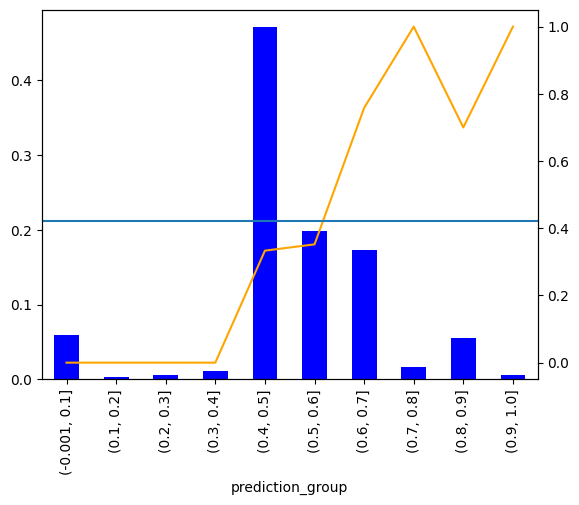

              precision    recall  f1-score   support

           0       0.58      0.99      0.73       207
           1       0.50      0.02      0.04       150

    accuracy                           0.58       357
   macro avg       0.54      0.50      0.38       357
weighted avg       0.55      0.58      0.44       357

AUC Score: 0.7578099838969404


In [37]:
present_scores(y_test, y_pred_proba, n_bins=10)

# Compute confusion matrix

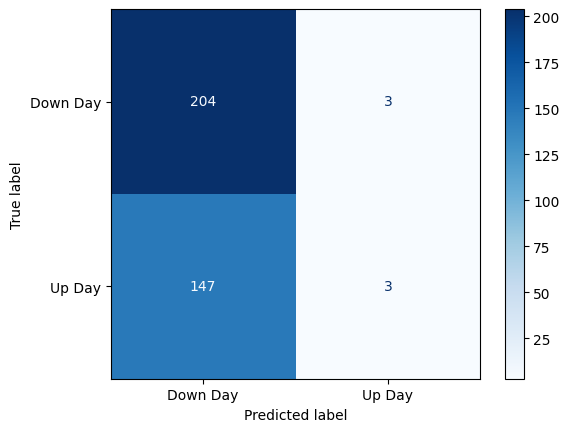

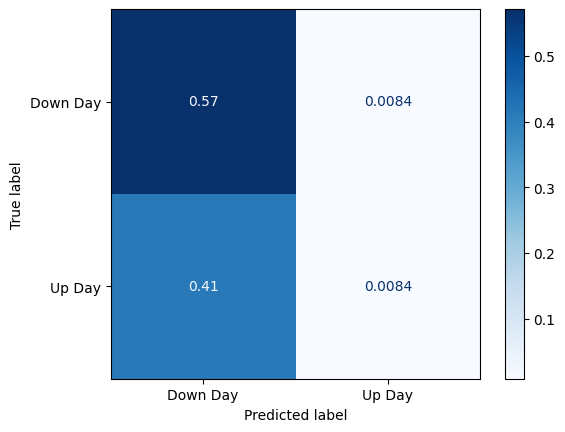

In [38]:
# Compute confusion matrix to evaluate the accuracy of the classification - displaying actual total values numbers per category

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)

plt.show()

# Compute confusion matrix to evaluate the accuracy of the classification - displaying normalized values numbers

cm = confusion_matrix(y_test, y_pred, normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)

plt.show()



In [39]:

# הבר (המקל) הכחול מתאר כמה תצפיות יש בכל בין של הסתברות, למשל, בבין של 0.3 עד 0.4 יש 38% מהתצפיות
# הקו הכחול לעומתו, מתאר את המציאות - כמה ״1״-ים יש לנו במציאות
# הקו הכתום, תמיד צריך להיות משווה לקו הכחול, מעיד על אחוז הדיוק בבין
# נשים את הסף כל עוד הקו הכתום מעל הקו הכחול, או במינימום בנק׳ המפגש שלהם
# במודל טוב - ככל שההתסברות גבוהה יותר, כך הוא גם צודק יותר, ולכן בגדול הקו הכתום צריך לעלות, אבל זה לא המצב אצלנו

In [40]:
#create the profit function - based on the percentage of change in the "market cap percentage" column

# create prediction column in the "test" dataframe based on the model results, set it to binary number instead of True / False

test['prediction'] = y_pred.astype(int)
# test = test.reset_index()
test['profit_percentage'] = test['diff_in_mc_perc'] * test['prediction']
profit_perc_sum = round(test['profit_percentage'].sum(), 3)
profit_perc_mean = round(profit_perc_sum / test[test['prediction']==1].shape[0], 3)

print("The total profit in percentage after investing in APH stock is:",profit_perc_mean,"%")

The total profit in percentage after investing in Google stock is: 0.553 %
